Pairwise tests (cartesian product):



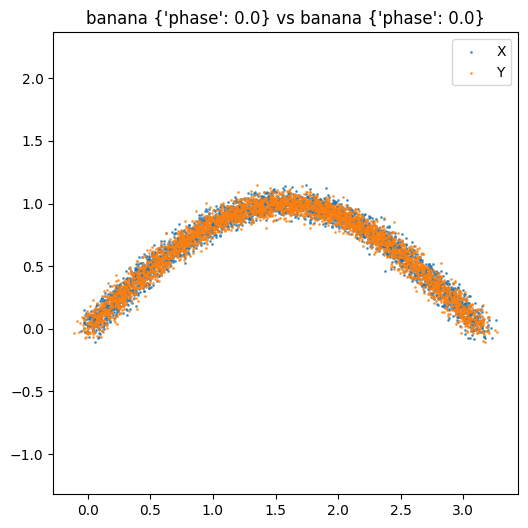

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


KeyboardInterrupt: 

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
from sklearn.manifold import SpectralEmbedding


try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################


def spectral_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    k = k if k is not None else min(n - 1, Xc.shape[1])
    se = SpectralEmbedding(n_components=k, affinity='rbf')
    #se = SpectralEmbedding(n_components=k, affinity='nearest_neighbors', n_neighbors=min(10, n-1))
    return se.fit_transform(Xc)

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

def pca_embedding_with_eigvals_and_evecs(X, k=None):
    Xc = X - X.mean(axis=0)
    k = k if k else X.shape[1]
    pca = PCA(n_components=k)
    pca.fit(Xc)
    AX = pca.transform(Xc)
    eigvals = pca.explained_variance_
    evecs = pca.components_.T  # d x k
    return AX, eigvals, evecs

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted): # we don't need to pass in sorted arrays, we can change this later
    n, m = len(u_sorted), len(v_sorted)
    a = np.ones(n) / n
    b = np.ones(m) / m
    return (ot.lp.emd2_1d(u_sorted, v_sorted, a, b)) # W2^2

def assignment_sliced_wasserstein(X, Y, AX, BY, eigvals_X=None, eigvals_Y=None, eigvecs_X=None, eigvecs_Y=None, print_pairings=False):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            # positive‐sign cost (both arrays already ascending)
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            # negative‐sign cost: reverse the sorted array before negating
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C[i, j] = min(d_pos, d_neg)
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()

    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
        print("\nRISWIE Axis Pairings:")
        for idx in range(len(row_ind)):
            i, j = row_ind[idx], col_ind[idx]
            print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                  f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}, "
                  f"contribution={C[i, j]:.6f}")
    return np.sqrt((1 / k) * total_cost)
 # to hopefully be a pseudometric - regardless, matching units


def assignment_weighted_during(X, Y, AX, BY, eigvals_X, eigvals_Y, eigvecs_X=None, eigvecs_Y=None, weight_type='geometric', print_pairings=False):
    k = AX.shape[1]
    # Normalize eigenvalues to sum to 1 if desired, or use raw eigvals for absolute weighting
    #eigvals_X = eigvals_X / eigvals_X.sum()
    #eigvals_Y = eigvals_Y / eigvals_Y.sum()
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            cost = min(d_pos, d_neg)
            if weight_type == 'geometric':
                w = np.sqrt(eigvals_X[i] * eigvals_Y[j]) # this pairs low variance axes with high variance axes
                #w = np.exp(-np.sqrt(eigvals_X[i] * eigvals_Y[j])) # maybe this will not do that
            elif weight_type == 'arithmetic':
                w = 0.5 * (eigvals_X[i] + eigvals_Y[j])
            else:
                raise ValueError("weight_type must be 'geometric' or 'arithmetic'")
            C[i, j] = w * cost
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
        print("\nRISWIE-Z (Weighted-During) Axis Pairings:")
        for idx in range(len(row_ind)):
            i, j = row_ind[idx], col_ind[idx]
            print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                  f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}, "
                  f"contribution={C[i, j]:.6f}")
    return np.sqrt(total_cost / k)

def assignment_weighted_after(X, Y, AX, BY, eigvals_X, eigvals_Y, eigvecs_X=None, eigvecs_Y=None, weight_type='geometric', print_pairings=False):
    k = AX.shape[1]
    # Do NOT normalize eigenvalues beforehand
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C[i, j] = min(d_pos, d_neg)
    row_ind, col_ind = linear_sum_assignment(C)
    costs = C[row_ind, col_ind]
    # Compute geometric mean weights for assigned pairs (using raw eigvals)
    if weight_type == 'geometric':
        weights = np.sqrt(eigvals_X[row_ind] * eigvals_Y[col_ind])
    elif weight_type == 'arithmetic':
        weights = 0.5 * (eigvals_X[row_ind] + eigvals_Y[col_ind])
    else:
        raise ValueError("weight_type must be 'geometric' or 'arithmetic'")
    weights_sum = weights.sum()
    # Normalize weights to sum to 1
    weights = weights / weights_sum if weights_sum > 0 else np.ones_like(weights)/k
    total_cost = (weights * costs).sum()
    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
            print("\nRISWIE-J (Weighted-After) Axis Pairings:")
            for idx in range(len(row_ind)):
                i, j = row_ind[idx], col_ind[idx]
                cost = costs[idx]
                weight = weights[idx]
                contribution = weight * cost
                print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                    f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}")
                print(f"    W2={cost:.6f} | weight={weight:.6f} | weighted contribution={contribution:.6f}")
    return np.sqrt(total_cost)

def softmin_sign(C_pos, C_neg, beta=10.0):
    # Soft-min over sign, shape (k, k)
    w = 1.0 / (1.0 + np.exp(beta * (C_pos - C_neg)))
    return w * C_pos + (1 - w) * C_neg

def assignment_sliced_wasserstein_soft_sinkhorn(X, Y, AX, BY, epsilon=0.08, beta=5.0, n_iter=50000):
    """
    Differentiable (soft) assignment sliced Wasserstein using POT Sinkhorn.
    """
    k = AX.shape[1]
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C_pos = np.zeros((k, k))
    C_neg = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C_pos[i, j] = d_pos
            C_neg[i, j] = d_neg
    # Soft sign selection
    C_soft = softmin_sign(C_pos, C_neg, beta=beta)

    # Uniform marginals
    a = np.ones(k) / k
    b = np.ones(k) / k

    # Use POT's Sinkhorn algorithm
    P = ot.sinkhorn(a, b, C_soft, reg=epsilon, numItermax=n_iter)
    total_cost = np.sum(P * C_soft)
    return np.sqrt(total_cost / k)

def assignment_sinkhorn_weighted(X, Y, AX, BY, eigvals_X, eigvals_Y, epsilon=0.08, beta=5.0, n_iter=50000):
    """
    Soft assignment weighted RISWIE (Sinkhorn):
      - Uses geometric mean weights W_ij = sqrt(eigval_X[i] * eigval_Y[j])
      - Applies weights after soft Sinkhorn assignment
      - Normalizes by the sum of W * P
    """
    k = AX.shape[1]
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C_pos = np.zeros((k, k))
    C_neg = np.zeros((k, k))

    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C_pos[i, j] = d_pos
            C_neg[i, j] = d_neg

    # Soft sign selection
    C_soft = softmin_sign(C_pos, C_neg, beta=beta)

    # Uniform marginals
    a = np.ones(k) / k
    b = np.ones(k) / k

    # Sinkhorn assignment
    P = ot.sinkhorn(a, b, C_soft, reg=epsilon, numItermax=n_iter)  # shape (k, k)

    # Geometric weights (not normalized yet)
    W = np.sqrt(np.outer(eigvals_X, eigvals_Y))  # shape (k, k)

    # Compute weighted cost and normalization
    weighted_cost = np.sum(W * P * C_soft)
    normalization = np.sum(W * P)

    D = np.sqrt(weighted_cost / normalization)
    return D


###

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if X.shape[1] != Y.shape[1]: # need to live in same dimensional space
        raise ValueError(f"OT: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=10000, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Procrustes: Shape mismatch {X.shape} vs {Y.shape}")
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"SW: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0),
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0),
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)),
        dict(mean=np.ones(2)),
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            try:
                t0 = time.time()
                AX = diffusion_embedding(X, k=k, t=t)
                BY = diffusion_embedding(Y, k=k, t=t)
                # Optionally rescale to match variance for fair distance comparison
                # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
                scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
                AX *= scale
                BY *= scale
                dist = distance_fn(X, Y, AX, BY)
                t1 = time.time()
                results[(k, t)] = (dist, t1 - t0)
            except Exception as e:
                results[(k, t)] = (str(e), None)  # capture any errors
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        try:
            t0 = time.time()
            dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
            t1 = time.time()
            results[n_proj] = (dist, t1 - t0)
        except Exception as e:
            results[n_proj] = (str(e), None)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [10]
    t_values = [0, 1, 10]
    n_proj_values = [100, 1000, 10000]

    rows = []
    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 3500
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        # Scale PCA embeddings to match input variance - heuristic
        # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale
        BY *= scale
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        try:
            t0 = time.time()
            d_ot = standard_ot(X, Y)
            t1 = time.time()
            ot_time = t1 - t0
        except ValueError as e:
            d_ot = str(e)
            ot_time = None

        try:
            t0 = time.time()
            d_proc = procrustes_ot(X, Y)
            t1 = time.time()
            procrustes_time = t1 - t0
        except ValueError as e:
            d_proc = str(e)
            procrustes_time = None

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)' if pca_time is not None else '   SlicedWasserstein-PCA:   Error')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)' if gw_time is not None else '   Gromov-Wasserstein:      Error')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)' if ot_time is not None else '   Standard OT:             Error')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)' if procrustes_time is not None else '   Procrustes OT:           Error')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      k={kk:3d}, t={tt:2d}: Error')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      n_proj={n_proj:4d}: Error')
        print()
        row = {
            'A_type': dtype1,
            'A_params': str(p1),
            'B_type': dtype2,
            'B_params': str(p2),
            'sliced_pca': d_pca,
            'sliced_pca_time': pca_time,
            'gromov_wasserstein': d_gw,
            'gromov_wasserstein_time': gw_time,
            'standard_ot': d_ot,
            'standard_ot_time': ot_time,
            'procrustes_ot': d_proc,
            'procrustes_ot_time': procrustes_time,
        }
        # Add diffusion results
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            row[f'diffusion_k{kk}_t{tt}'] = dist
            row[f'diffusion_k{kk}_t{tt}_time'] = t_elapsed
        # Add SW projections
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            row[f'sw_proj{n_proj}'] = dist
            row[f'sw_proj{n_proj}_time'] = t_elapsed
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv('all_scores_per_pair.csv', index=False)

if __name__ == '__main__':
    test_framework()

Pairwise tests (cartesian product):



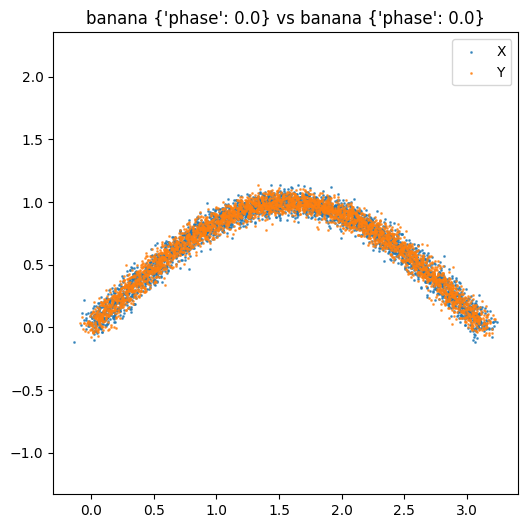

KeyboardInterrupt: 

In [ ]:
def compute_distance_matrix(distance_fn, embedding_fn, k=2, out_path="distance_matrix.csv"):
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    labels = []

    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))
            labels.append(f"{dtype}_{str(params)}")

    n = 5
    dist_matrix = np.zeros((len(configs), len(configs)))

    for i, (dtype1, p1) in enumerate(configs):
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        AX = embedding_fn(X, k)
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale

        for j, (dtype2, p2) in enumerate(configs):
            if j < i:
                dist_matrix[i, j] = dist_matrix[j, i]
                continue

            Y = generate_dataset(dtype2, n=n, d=2, **p2)
            BY = embedding_fn(Y, k)
            scale = np.sqrt(np.trace(np.cov(Y.T)) / np.trace(np.cov(BY.T)))
            BY *= scale

            try:
                dist = distance_fn(X, Y, AX, BY)
            except Exception as e:
                print(f"Error between {labels[i]} and {labels[j]}: {e}")
                dist = np.nan

            dist_matrix[i, j] = dist

    df = pd.DataFrame(dist_matrix, index=labels, columns=labels)
    df.to_csv(out_path)
    print(f"Saved distance matrix to {os.path.abspath(out_path)}")

    return df

def check_triangle_inequality(df):
    D = df.values
    labels = df.index.tolist()
    n = len(D)

    violations = []
    max_violation = 0.0

    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i == j or j == k or i == k:
                    continue
                lhs = D[i, k]
                rhs = D[i, j] + D[j, k]
                if not np.isnan(lhs) and not np.isnan(rhs) and lhs > rhs + 1e-8:
                    violation_amt = lhs - rhs
                    violations.append((labels[i], labels[j], labels[k], violation_amt))
                    max_violation = max(max_violation, violation_amt)

    print(f"\nChecked {len(violations)} triangle inequality violations.")
    if violations:
        print(f"Max violation: {max_violation:.6f}")
        print("Examples:")
        for a, b, c, v in sorted(violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("All triangles satisfied the triangle inequality.")

    return violations

def filter_2d_only_violations(violations):
    def is_2d(label):
        return not label.startswith("cylinder")

    pure_2d_violations = [
        (a, b, c, v) for (a, b, c, v) in violations
        if is_2d(a) and is_2d(b) and is_2d(c)
    ]

    print(f"\nTriangle inequality violations among only 2D datasets: {len(pure_2d_violations)}")
    if pure_2d_violations:
        max_violation = max(pure_2d_violations, key=lambda x: x[3])[3]
        print(f"Max 2D-only violation: {max_violation:.6f}")
        for a, b, c, v in sorted(pure_2d_violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("✅ No triangle inequality violations among 2D-only datasets.")

    return pure_2d_violations

if __name__ == '__main__':
    #df = compute_distance_matrix(
    #    distance_fn=assignment_sliced_wasserstein,
    #    embedding_fn=lambda X, k: diffusion_embedding(X, k=k, t=1),  # you can change t=1 to other values
    #    k=10000000000000,
    #    out_path="shape_distances_diffusion_t1.csv"
    #)

    #violations = check_triangle_inequality(df)
    #filter_2d_only_violations(violations)

    df = compute_distance_matrix(
        distance_fn=assignment_sliced_wasserstein,
        embedding_fn=pca_embedding,
        k=2,
        out_path="shape_distances_pca.csv"
    )

    violations = check_triangle_inequality(df)
    filter_2d_only_violations(violations)


Saved distance matrix to c:\Users\zakkh\PAIRSWEEP\shape_distances_pca.csv

Checked 188 triangle inequality violations.
Max violation: 2.706902
Examples:
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, cylinder_{'angle': 0.0}) + D(cylinder_{'angle': 0.0}, swissroll_{}) by 2.706902
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, cylinder_{'angle': 0.0}) + D(cylinder_{'angle': 0.0}, normal_{'mean': array([1., 1.])}) by 2.706902
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, swissroll_{}) by 2.527591
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, normal_{'mean': array([1., 1.])}) by 2.527591
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, cylinder_{'angle': 1.570796326794

In [ ]:
import numpy as np
import time
import pandas as pd

def perturb_points(X, kind='gaussian', magnitude=0.1):
    """Add isotropic Gaussian noise (or other) to a point cloud."""
    if kind == 'gaussian':
        return X + magnitude * np.random.randn(*X.shape)
    # You can add other perturbation types here.
    raise NotImplementedError(f"Perturbation kind '{kind}' not implemented.")

def eval_metric_relative_change(metric_fn, X, Y, n_trials=30, perturb_kind='gaussian', magnitude=0.1, **metric_kwargs):
    """Run repeated trials for a metric, return relative normalized changes, SNR, total time."""

    # --- Center X and Y before running any metric ---
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)

    # Compute baseline distance (unperturbed)
    t0 = time.time()
    D_baseline = metric_fn(X_centered, Y_centered, **metric_kwargs)
    t1 = time.time()
    baseline_time = t1 - t0

    rel_changes = []
    times = []

    for i in range(n_trials):
        X_pert = perturb_points(X, kind=perturb_kind, magnitude=magnitude)
        X_pert_centered = X_pert - X_pert.mean(axis=0)  # <--- recenter after perturbing
        t0 = time.time()
        D_pert = metric_fn(X_pert_centered, Y_centered, **metric_kwargs)
        t1 = time.time()
        times.append(t1 - t0)
        if np.abs(D_baseline) > 1e-10:
            rel_change = np.abs((D_pert - D_baseline) / D_baseline)
        else:
            rel_change = np.nan # Avoid division by zero
        rel_changes.append(rel_change)

    rel_changes = np.array(rel_changes)
    mean_rel_change = np.nanmean(rel_changes)
    std_rel_change = np.nanstd(rel_changes)
    snr_a = mean_rel_change / std_rel_change if std_rel_change > 1e-12 else np.nan
    total_time = baseline_time + np.nansum(times)

    return {
        'mean_rel_change': mean_rel_change,
        'std_rel_change': std_rel_change,
        'snr_a': snr_a,
        'total_time': total_time,
        'D_baseline': D_baseline,
        'rel_changes': rel_changes,
    }


# --- Plug in your algorithms here. Each must be a function metric(X, Y, ...) ---

def metric_pca(X, Y):
    k = min(X.shape[1], Y.shape[1])
    AX = pca_embedding(X, k)
    BY = pca_embedding(Y, k)
    scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
    AX *= scale # this scaling doesn't actually matter. it just scales the distances by s which will then be cancelled in relative normal change or SNR.
    BY *= scale
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_diffusion(X, Y, k=10, t=1):
    AX = diffusion_embedding(X, k=k, t=t)
    BY = diffusion_embedding(Y, k=k, t=t)
    scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
    AX *= scale
    BY *= scale
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_gromov(X, Y):
    return gromov_wasserstein(X, Y)

def metric_ot(X, Y):
    return standard_ot(X, Y)

def metric_procrustes_ot(X, Y):
    return procrustes_ot(X, Y)

def metric_sliced_wasserstein(X, Y):
    return sliced_wasserstein(X, Y, n_proj=1000, p=2, seed=42)

# ---- List of metrics to try ---
metric_list = [
    ('Standard OT', metric_ot),
    ('Standard Sliced Wasserstein', metric_sliced_wasserstein),
    ('SlicedWasserstein-PCA', metric_pca),
    #('Diffusion-k100-t10', lambda X,Y: metric_diffusion(X,Y,k=100,t=19)),
    #('Diffusion-k100-t25', lambda X,Y: metric_diffusion(X,Y,k=100,t=25)),
    ('Procrustes OT', metric_procrustes_ot),
    ('Gromov-Wasserstein', metric_gromov),
]

# ---- MAIN: Loop over datasets, metrics, and output ----
def run_all_relative_change_experiments(
        dataset_types, dataset_params, 
        n_trials=30, perturb_kind='gaussian', magnitude=0.1):

    rows = []
    DIAGONAL_FIRST = True
    for iterations in range(2): 
        if iterations == 1: DIAGONAL_FIRST = False
        for dtype1 in dataset_types:
            for p1 in dataset_params[dtype1]:
                for dtype2 in dataset_types:
                    for p2 in dataset_params[dtype2]:
                        if DIAGONAL_FIRST and (dtype1 != dtype2 or p1 != p2): continue
                        if not DIAGONAL_FIRST and (dtype1 == dtype2 and p1 == p2): continue
                        params1 = p1.copy()
                        X = generate_dataset(dtype1, **params1)

                        params2 = p2.copy()
                        Y = generate_dataset(dtype2, **params2)

                        for metric_name, metric_fn in metric_list:
                            print(f"Testing {metric_name}: {dtype1} {p1} vs {dtype2} {p2}")
                            try:
                                res = eval_metric_relative_change(
                                    metric_fn, X, Y, 
                                    n_trials=n_trials, 
                                    perturb_kind=perturb_kind,
                                    magnitude=magnitude
                                )
                            except Exception as e:
                                print(f"Error with {metric_name} on {dtype1} vs {dtype2}: {e}")
                                res = {k: np.nan for k in ['mean_rel_change', 'std_rel_change', 'snr_a', 'total_time', 'D_baseline', 'rel_changes']}
                            row = {
                                'A_type': dtype1,
                                'A_params': str(p1),
                                'B_type': dtype2,
                                'B_params': str(p2),
                                'metric': metric_name,
                                'mean_rel_change': res['mean_rel_change'],
                                'std_rel_change': res['std_rel_change'],
                                'snr_a': res['snr_a'],
                                'total_time': res['total_time'],
                                'D_baseline': res['D_baseline'],
                                'rel_changes': res['rel_changes'],
                                # Optionally log n/d for reference
                                'A_n': params1.get('n', None),
                                'A_d': params1.get('d', None),
                                'B_n': params2.get('n', None),
                                'B_d': params2.get('d', None),
                            }
                            rows.append(row)
                            print(f"  mean_rel_change={row['mean_rel_change']:.4g}  std_rel_change={row['std_rel_change']:.4g}  snr_a={row['snr_a']:.4g}  total_time={row['total_time']:.2f}s")
                            print()
    df = pd.DataFrame(rows)
    df.to_csv('relative_change_SNR_trials.csv', index=False)
    return df

# Datasets
from sklearn import datasets

def generate_dataset(kind, n=1000, d=2, **kwargs):
    # Bananas in 2D or 3D (Z=0)
    if kind == 'banana':
        phase = kwargs.get('phase', 0.0)
        noise = kwargs.get('noise', 0.05)
        t = np.linspace(0, np.pi, n)
        if d < 3:
            X = np.vstack([t, np.sin(t + phase)]).T
            if d == 2:
                pass
            elif d == 3:
                X = np.c_[X, np.zeros(n)]
        else:
            X = np.zeros((n, d))
            X[:, 0] = t
            X[:, 1] = np.sin(t + phase)
        X += noise * np.random.randn(n, d)
        return X

    # High-dim isotropic or anisotropic normal
    if kind == 'normal':
        mean = np.zeros(d)
        mean_shift = kwargs.get('mean_shift', 0.0)
        mean = mean + mean_shift
        if kwargs.get('cov', '') == 'anisotropic':
            # Anisotropic: decay along dims
            eigvals = np.linspace(1.0, 0.1, d)
            cov = np.diag(eigvals)
        else:
            cov = np.eye(d)
        return np.random.multivariate_normal(mean, cov, n)

    # Swiss roll, embed in high-d
    if kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        X = X / X.std()  # normalize variance
        if d > 3:
            zeros = np.zeros((n, d - 3))
            X = np.c_[X, zeros]
        elif d < 3:
            X = X[:, :d]
        return X[:, :d]

    # Gaussian Mixture (clusters)
    if kind == 'gaussian_mixture':
        k = kwargs.get('k', 3)
        spread = kwargs.get('spread', 5.0)
        X = []
        for i in range(k):
            mean = np.random.uniform(-spread, spread, size=d)
            cov = np.eye(d) * np.random.uniform(0.5, 2.0)
            pts = np.random.multivariate_normal(mean, cov, n // k)
            X.append(pts)
        X = np.vstack(X)
        if X.shape[0] < n:
            # add some more
            X = np.vstack([X, np.random.multivariate_normal(np.zeros(d), np.eye(d), n - X.shape[0])])
        X = X[:n]
        return X

    # Cylinder
    if kind == 'cylinder':
        angle = kwargs.get('angle', 0.0)
        height = kwargs.get('height', 2.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-height/2, height/2, n)
        X = np.zeros((n, d))
        X[:, 0] = np.cos(theta + angle)
        X[:, 1] = np.sin(theta + angle)
        if d > 2:
            X[:, 2] = z
        # embed in higher d if needed
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    # Torus
    if kind == 'torus':
        R = kwargs.get('R', 2.0)
        r = kwargs.get('r', 1.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        phi = np.random.uniform(0, 2*np.pi, n)
        X = np.zeros((n, d))
        X[:, 0] = (R + r * np.cos(phi)) * np.cos(theta)
        X[:, 1] = (R + r * np.cos(phi)) * np.sin(theta)
        if d > 2:
            X[:, 2] = r * np.sin(phi)
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    raise ValueError(f"Unknown dataset kind: {kind}")

# Example usage:
DATASET_PARAMS = {
    # Mixture of Gaussians (clusters)
    'gaussian_mixture': [
        dict(n=5000, d=64, k=64, spread=20.0), # 10 clusters, hi-dim
        dict(n=3000, d=128, k=12, spread=20.0),    # 12 clusters, hi-dim, not too concentrated
        dict(n=1000, d=3, k=4, spread=5.0),    # 4 clusters, low-dim
        dict(n=3000, d=10, k=8, spread=10.0),  # 8 clusters, mid-dim
    ],
    # Classic 2D banana curve, but also phase shift and noise variants
    'banana': [
        dict(n=1000, d=2, phase=0.0, noise=0.05),  # classic
        dict(n=2500, d=2, phase=1.0, noise=0.10),  # more phase + noise
        dict(n=5000, d=3, phase=0.5, noise=0.07),  # 3D banana (uses Z=0)
    ],
    # Swiss roll for nontrivial geometry
    'swissroll': [
        dict(n=1500, d=3),   # classic
        dict(n=3000, d=10),  # embedded in higher d
        dict(n=10000, d=50),  # even higher d
    ],
    # Torus, good for testing nontrivial topology
    'torus': [
        dict(n=1000, d=3, R=2.0, r=1.0),
        dict(n=10000, d=10, R=3.0, r=1.5),  # 10D, torus in first 3 dims
    ],
    # Standard high-dim normal (with anisotropy)
    'normal': [
        dict(n=1000, d=512), # interesting mesh of dimension and point count
        dict(n=100, d=2), # very low
        dict(n=1000, d=3),  # low
        dict(n=2500, d=10),  # medium
        dict(n=3500, d=50, cov='anisotropic'),  # high, anisotropic
        dict(n=10000, d=128),  # high, isotropic
        dict(n=5000, d=256, mean_shift=5.0),  # very high, shifted
    ],
    # Cylinder-like
    'cylinder': [
        dict(n=2000, d=3, angle=0.0, height=2.0),
        dict(n=10000, d=10, angle=0.5, height=3.0),  # embed cylinder in 10D
    ]
}

run_all_relative_change_experiments(
     dataset_types=list(DATASET_PARAMS.keys()),
     dataset_params=DATASET_PARAMS,
     n_trials=10,
     perturb_kind='gaussian',
     magnitude=0.1
 )



Testing Standard OT: gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0}
  mean_rel_change=6.276e-06  std_rel_change=3.781e-06  snr_a=1.66  total_time=64.44s

Testing Standard Sliced Wasserstein: gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0}
  mean_rel_change=0.0001487  std_rel_change=2.625e-05  snr_a=5.665  total_time=10.53s

Testing SlicedWasserstein-PCA: gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0}
  mean_rel_change=0.0005163  std_rel_change=0.0004466  snr_a=1.156  total_time=22.13s

Testing Procrustes OT: gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0} vs gaussian_mixture {'n': 5000, 'd': 64, 'k': 64, 'spread': 20.0}
  mean_rel_change=2.975e-05  std_rel_change=1.314e-05  snr_a=2.265  total_time=185.12s

Testing Gromov-Wasserste

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


  mean_rel_change=0.007184  std_rel_change=0.008253  snr_a=0.8706  total_time=4009.39s

Testing Standard OT: gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0} vs gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0}
  mean_rel_change=3.835e-06  std_rel_change=1.95e-06  snr_a=1.967  total_time=30.34s

Testing Standard Sliced Wasserstein: gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0} vs gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0}
  mean_rel_change=0.0001131  std_rel_change=1.505e-05  snr_a=7.514  total_time=9.23s

Testing SlicedWasserstein-PCA: gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0} vs gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0}
  mean_rel_change=0.0003761  std_rel_change=0.0003701  snr_a=1.016  total_time=98.03s

Testing Procrustes OT: gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0} vs gaussian_mixture {'n': 3000, 'd': 128, 'k': 12, 'spread': 20.0}
  mean_rel_change

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


KeyboardInterrupt: 

In [ ]:
import numpy as np

# Your code for embedding and distance should be imported/available already

X = np.array([
    [1, 0],
    [-1, 0]
])
Y = np.array([
    [0, 1],
    [0, -1]
])
Z = np.array([
    [np.sqrt(2)/2, np.sqrt(2)/2],
    [-np.sqrt(2)/2, -np.sqrt(2)/2]
])

# PCA embedding for 2D sets
AX = pca_embedding(X, k=2)
AY = pca_embedding(Y, k=2)
AZ = pca_embedding(Z, k=2)

# Assignment Sliced Wasserstein distances
d_XY = assignment_sliced_wasserstein(X, Y, AX, AY)
d_YZ = assignment_sliced_wasserstein(Y, Z, AY, AZ)
d_XZ = assignment_sliced_wasserstein(X, Z, AX, AZ)

print(f"d(X, Y) = {d_XY}")
print(f"d(Y, Z) = {d_YZ}")
print(f"d(X, Z) = {d_XZ}")
print("Triangle inequality: d(X, Z) <= d(X, Y) + d(Y, Z)?", d_XZ <= d_XY + d_YZ)


NameError: name 'pca_embedding' is not defined

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment as hungarian
from collections import Counter
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# 1) Convert image to weighted point cloud via intensity-based replication
def image_to_point_cloud(image, max_reps=5):
    coords = []
    scaled = (image / image.max()) * max_reps
    for (i, j), val in np.ndenumerate(scaled):
        reps = int(round(val))
        coords.extend([(i, j)] * reps)
    if len(coords) == 0:
        coords = [(image.shape[0]//2, image.shape[1]//2)]
    return np.array(coords)

# 2) PCA embedding of point cloud
def pca_embedding(X, k=2):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k)
    return pca.fit_transform(Xc)

# 3) Diffusion embedding of point cloud
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    epsilon = epsilon if epsilon is not None else np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d + 1e-8))
    P = D_inv_sqrt @ K @ D_inv_sqrt
    if k >= n - 1:
        vals, vecs = eigh(P)
        order = np.argsort(vals)[::-1]
        vals, vecs = vals[order], vecs[:, order]
    else:
        vals, vecs = eigsh(P, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals, vecs = vals[order], vecs[:, order]
    lambdas = vals[1:k+1]
    phis = vecs[:, 1:k+1]
    return phis * (lambdas**t)

# 4) RISWIE distance between two embedded clouds (handles different lengths)
def riswie_distance(AX, BY):
    k = AX.shape[1]
    AX_sorted = [np.sort(AX[:, i]) for i in range(k)]
    BY_sorted = [np.sort(BY[:, i]) for i in range(k)]
    C = np.zeros((k, k))
    for i in range(k):
        a = AX_sorted[i]
        for j in range(k):
            b = BY_sorted[j]
            L = min(len(a), len(b))
            idx_a = np.round(np.linspace(0, len(a)-1, L)).astype(int)
            idx_b = np.round(np.linspace(0, len(b)-1, L)).astype(int)
            a_sub = a[idx_a]
            b_sub = b[idx_b]
            d_pos = np.mean((a_sub - b_sub)**2)
            b_neg = -b[::-1][idx_b]
            d_neg = np.mean((a_sub - b_neg)**2)
            C[i, j] = min(d_pos, d_neg)
    row, col = linear_sum_assignment(C)
    total = C[row, col].sum()
    return np.sqrt(total / k)

# Load digit dataset MNIST
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)
images = X.reshape(-1, 28, 28)
labels = y

#all_idx = np.arange(len(labels))
#train_idx, test_idx = train_test_split(
#    all_idx,
#    test_size=0.2,       # e.g. 80/20 split
#    random_state=42,
#    stratify=labels
#)
n = 400  # or any number you want
all_idx = np.arange(n)
# Only use the first n labels
subset_labels = labels[:n]

train_idx, test_idx = train_test_split(
    all_idx,
    test_size=0.2,       # 80/20 split
    random_state=42,
    stratify=subset_labels
)

# Build embeddings
pca_embeddings = []
diff_embeddings = []
for img in images:
    pc = image_to_point_cloud(img, max_reps=5)
    pca_embeddings.append(pca_embedding(pc, k=2))
    #diff_embeddings.append(diffusion_embedding(pc, k=5, t=1))

# Classification (kNN)
def knn_classify(embs, train_idx, test_idx, labels, k=3):
    preds = []
    for ti in test_idx:
        dists = []
        for tr in train_idx:
            d = riswie_distance(embs[ti], embs[tr])
            dists.append((d, labels[tr]))
        knn = sorted(dists)[:k]
        pred = Counter([lab for _, lab in knn]).most_common(1)[0][0]
        preds.append(pred)
    true = labels[test_idx]
    return np.mean(np.array(preds) == true)

acc_pca = knn_classify(pca_embeddings, train_idx, test_idx, labels, k=3)
print(f"PCA-RISWIE kNN accuracy:        {acc_pca:.2%}")
#acc_diff = knn_classify(diff_embeddings, train_idx, test_idx, labels, k=3)
#print(f"Diffusion-RISWIE kNN accuracy:  {acc_diff:.2%}")

# Clustering (Agglomerative)
def cluster_accuracy(embs, labels, train_idx, test_idx, n_clusters=10):
    n = len(embs)
    # 1) Compute full pairwise RISWIE distance matrix
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = riswie_distance(embs[i], embs[j])
            D[i, j] = D[j, i] = d

    # 2) Run clustering on all points
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        linkage='average'
    )
    clusters = clustering.fit_predict(D)

    # 3) Build confusion matrix *only* on the TRAIN set
    conf = np.zeros((n_clusters, n_clusters), int)
    for i in train_idx:
        cl = clusters[i]
        true = labels[i]
        conf[cl, true] += 1

    # 4) Hungarian assignment to maximize train‐set agreement
    row, col = hungarian(-conf)
    mapping = {r: c for r, c in zip(row, col)}

    # 5) Apply mapping to TEST set and compute accuracy
    test_preds = [mapping[clusters[i]] for i in test_idx]
    test_true  = [labels[i]           for i in test_idx]
    return np.mean([p == t for p, t in zip(test_preds, test_true)])

cluster_acc_pca = cluster_accuracy(pca_embeddings, labels, train_idx, test_idx, n_clusters=10)
print(f"PCA-RISWIE test‐set clustering accuracy: {cluster_acc_pca:.2%}")

cluster_acc_diff = cluster_accuracy(diff_embeddings, labels, train_idx, test_idx, n_clusters=10)
print(f"Diffusion-RISWIE test‐set clustering accuracy: {cluster_acc_diff:.2%}")


PCA-RISWIE kNN accuracy:        67.50%


MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.ndimage import rotate
from skimage.transform import AffineTransform, warp
import random

# 1. Randomly transform images
def random_transform(image):
    # Random rotation between -180 and 180 degrees
    angle = np.random.uniform(-180, 180)
    img = rotate(image, angle, reshape=False, order=1, mode='constant', cval=0.0)

    # Random horizontal flip
    if np.random.rand() > 0.5:
        img = np.fliplr(img)
    # Random vertical flip
    if np.random.rand() > 0.5:
        img = np.flipud(img)

    # Removed translation/AffineTransform part

    return img


# 2. Load MNIST, apply transformations
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)
images = X.reshape(-1, 28, 28)
labels = y

all_idx = np.arange(n)
subset_labels = labels[:n]

train_idx, test_idx = train_test_split(
    all_idx,
    test_size=0.2,       # 80/20 split
    random_state=42,
    stratify=subset_labels
)

# 3. Apply random transformation to every image
transformed_images = np.stack([random_transform(img) for img in images[:n]])

# 4. Flatten for Euclidean kNN
flat_images = transformed_images.reshape((n, -1))

# 5. Euclidean kNN (slow but easy to follow)
def knn_classify(flat_images, train_idx, test_idx, labels, k=3):
    preds = []
    train_images = flat_images[train_idx]
    train_labels = labels[train_idx]
    for ti in test_idx:
        test_img = flat_images[ti]
        dists = np.linalg.norm(train_images - test_img, axis=1)
        nn_idx = np.argsort(dists)[:k]
        nn_labels = train_labels[nn_idx]
        pred = Counter(nn_labels).most_common(1)[0][0]
        preds.append(pred)
    true = labels[test_idx]
    return np.mean(np.array(preds) == true)

acc_euc = knn_classify(flat_images, train_idx, test_idx, labels, k=3)
print(f"Euclidean kNN (k=3) on randomly transformed MNIST: {acc_euc:.2%}")

# 6. Clustering (optional, Euclidean on flattened images)
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment

def cluster_accuracy(flat_images, labels, train_idx, test_idx, n_clusters=10):
    n = len(flat_images)
    # Pairwise Euclidean distances
    D = np.linalg.norm(flat_images[:, None] - flat_images[None, :], axis=2)
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        linkage='average'
    )
    clusters = clustering.fit_predict(D)

    # Confusion matrix on train
    conf = np.zeros((n_clusters, n_clusters), int)
    for i in train_idx:
        cl = clusters[i]
        true = labels[i]
        conf[cl, true] += 1

    # Hungarian assignment to maximize agreement
    row, col = linear_sum_assignment(-conf)
    mapping = {r: c for r, c in zip(row, col)}

    # Test set accuracy
    test_preds = [mapping[clusters[i]] for i in test_idx]
    test_true = [labels[i] for i in test_idx]
    return np.mean([p == t for p, t in zip(test_preds, test_true)])

cluster_acc_euc = cluster_accuracy(flat_images, labels, train_idx, test_idx, n_clusters=10)
print(f"Euclidean clustering accuracy: {cluster_acc_euc:.2%}")


Euclidean kNN (k=3) on randomly transformed MNIST: 47.50%


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.ndimage import rotate
from skimage.transform import AffineTransform, warp
import random

# 1. Randomly transform images
def random_transform(image):
    # Random rotation between -180 and 180 degrees
    angle = np.random.uniform(-180, 180)
    img = rotate(image, angle, reshape=False, order=1, mode='constant', cval=0.0)
    # Random horizontal flip
    if np.random.rand() > 0.5:
        img = np.fliplr(img)
    # Random vertical flip
    if np.random.rand() > 0.5:
        img = np.flipud(img)
    return img

# 2. Convert image to weighted point cloud via intensity-based replication
def image_to_point_cloud(image, max_reps=5):
    coords = []
    scaled = (image / image.max()) * max_reps if image.max() > 0 else image
    for (i, j), val in np.ndenumerate(scaled):
        reps = int(round(val))
        coords.extend([(i, j)] * reps)
    if len(coords) == 0:
        coords = [(image.shape[0]//2, image.shape[1]//2)]
    return np.array(coords)

# 3. Sliced Wasserstein distance between two 2D point clouds
def sliced_wasserstein(A, B, n_proj=20):
    # A, B: arrays of (n_points, 2)
    # For each direction, project both clouds, sort, compute mean absolute diff
    dists = []
    for _ in range(n_proj):
        theta = np.random.uniform(0, 2*np.pi)
        dir = np.array([np.cos(theta), np.sin(theta)])
        Ap = np.dot(A, dir)
        Bp = np.dot(B, dir)
        # Equalize number of points by interpolation or subsampling
        n = min(len(Ap), len(Bp))
        Ap_sort = np.sort(Ap) if len(Ap) == n else np.sort(np.interp(np.linspace(0, len(Ap)-1, n), np.arange(len(Ap)), np.sort(Ap)))
        Bp_sort = np.sort(Bp) if len(Bp) == n else np.sort(np.interp(np.linspace(0, len(Bp)-1, n), np.arange(len(Bp)), np.sort(Bp)))
        dists.append(np.mean(np.abs(Ap_sort - Bp_sort)))
    return np.mean(dists)

# 4. Load MNIST, apply transformations
n = 400  # Reduce for speed; increase for full set if you have RAM/CPU
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)
images = X.reshape(-1, 28, 28)
labels = y

all_idx = np.arange(n)
subset_labels = labels[:n]

train_idx, test_idx = train_test_split(
    all_idx,
    test_size=0.2,       # 80/20 split
    random_state=42,
    stratify=subset_labels
)

# 5. Apply random transformation and get point cloud for every image
point_clouds = [image_to_point_cloud(random_transform(img), max_reps=5) for img in images[:n]]

# 6. Sliced Wasserstein kNN
def knn_classify_swd(point_clouds, train_idx, test_idx, labels, k=3):
    preds = []
    train_clouds = [point_clouds[i] for i in train_idx]
    train_labels = labels[train_idx]
    for ti in test_idx:
        test_cloud = point_clouds[ti]
        dists = []
        for tr, cloud in zip(train_idx, train_clouds):
            d = sliced_wasserstein(test_cloud, cloud, n_proj=100)
            dists.append((d, labels[tr]))
        knn = sorted(dists)[:k]
        pred = Counter([lab for _, lab in knn]).most_common(1)[0][0]
        preds.append(pred)
    true = labels[test_idx]
    return np.mean(np.array(preds) == true)

acc_swd = knn_classify_swd(point_clouds, train_idx, test_idx, labels, k=3)
print(f"Sliced Wasserstein kNN (k=3) on randomly transformed MNIST: {acc_swd:.2%}")

# 7. Clustering (optional, Sliced Wasserstein)
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import linear_sum_assignment

def cluster_accuracy_swd(point_clouds, labels, train_idx, test_idx, n_clusters=10):
    n = len(point_clouds)
    # Pairwise Sliced Wasserstein distances (can take a while)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = sliced_wasserstein(point_clouds[i], point_clouds[j], n_proj=10)
            D[i, j] = D[j, i] = d
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        linkage='average'
    )
    clusters = clustering.fit_predict(D)
    # Confusion matrix on train
    conf = np.zeros((n_clusters, n_clusters), int)
    for i in train_idx:
        cl = clusters[i]
        true = labels[i]
        conf[cl, true] += 1
    # Hungarian assignment to maximize agreement
    row, col = linear_sum_assignment(-conf)
    mapping = {r: c for r, c in zip(row, col)}
    # Test set accuracy
    test_preds = [mapping[clusters[i]] for i in test_idx]
    test_true = [labels[i] for i in test_idx]
    return np.mean([p == t for p, t in zip(test_preds, test_true)])

cluster_acc_swd = cluster_accuracy_swd(point_clouds, labels, train_idx, test_idx, n_clusters=10)
print(f"Sliced Wasserstein clustering accuracy: {cluster_acc_swd:.2%}")


Sliced Wasserstein kNN (k=3) on randomly transformed MNIST: 53.75%


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [ ]:
import os
import numpy as np
import trimesh

# --- Define your FAUST scan directory ---
SCAN_DIR = 'MPI-FAUST/training/scans'  # <-- set this!
from tqdm import tqdm  # <- import tqdm!

# --- Load all scans and subject/pose labels ---
clouds = []
labels = []   # subject ID for each scan
poses = []    # pose index for each scan

# FAUST: tr_scan_{nnn}.ply (nnn = s*10+p)
for i in range(50):  # 10 subjects x 10 poses
    fname = os.path.join(SCAN_DIR, f'tr_scan_{i:03d}.ply')
    mesh = trimesh.load(fname, process=False)
    points = np.array(mesh.vertices)
    clouds.append(points)
    subject = i // 10
    pose = i % 10
    labels.append(subject)
    poses.append(pose)

# --- Now clouds[i], labels[i], poses[i] are aligned ---

# --- Compute PCA Embeddings ---
k_pca = 3  # or higher if you prefer
pca_embs = [pca_embedding(X, k=k_pca) for X in clouds]
#scales = [np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(Z.T))) for X, Z in zip(clouds, pca_embs)]
#pca_embs = [Z*scale for Z, scale in zip(pca_embs, scales)]

# --- Compute pairwise distances (could use tqdm for progress bar) ---
n = len(clouds)
dist_matrix = np.zeros((n, n))
for i in tqdm(range(n), desc="Computing distances"):
    for j in range(n):
        dist_matrix[i, j] = assignment_sliced_wasserstein(
            clouds[i], clouds[j], pca_embs[i], pca_embs[j]
        )

# --- Top-1 subject retrieval accuracy (pose-invariant) ---
labels = np.array(labels)
correct = 0
for i in range(n):
    dists = dist_matrix[i, :].copy()
    dists[i] = np.inf  # don't match to self
    nn_idx = np.argmin(dists)
    if labels[nn_idx] == labels[i]:
        correct += 1
acc = correct / n
print(f"Top-1 nearest neighbor subject accuracy: {acc:.3f}")

poses = np.array(poses)  # ensure it's a NumPy array
correct = 0
for i in range(n):
    dists = dist_matrix[i, :].copy()
    dists[i] = np.inf  # don't match to self
    nn_idx = np.argmin(dists)
    if poses[nn_idx] == poses[i]:   # compare pose index instead of subject label
        correct += 1
acc = correct / n
print(f"Top-1 nearest neighbor pose accuracy: {acc:.3f}")



Computing distances: 100%|██████████| 50/50 [15:44<00:00, 18.89s/it]

Top-1 nearest neighbor subject accuracy: 0.260
Top-1 nearest neighbor pose accuracy: 0.660


: 

In [ ]:
import numpy as np
import os
import pandas as pd
import time
from scipy.stats import ttest_rel
import random

# ============ Dataset Generation & IO ==============
def generate_dataset(kind, n=1000, d=2, **kwargs):
    # Bananas in 2D or 3D (Z=0)
    if kind == 'banana':
        phase = kwargs.get('phase', 0.0)
        noise = kwargs.get('noise', 0.05)
        t = np.linspace(0, np.pi, n)
        if d < 3:
            X = np.vstack([t, np.sin(t + phase)]).T
            if d == 2:
                pass
            elif d == 3:
                X = np.c_[X, np.zeros(n)]
        else:
            X = np.zeros((n, d))
            X[:, 0] = t
            X[:, 1] = np.sin(t + phase)
        X += noise * np.random.randn(n, d)
        return X

    # High-dim isotropic or anisotropic normal
    if kind == 'normal':
        mean = np.zeros(d)
        mean_shift = kwargs.get('mean_shift', 0.0)
        mean = mean + mean_shift
        if kwargs.get('cov', '') == 'anisotropic':
            # Anisotropic: decay along dims
            eigvals = np.linspace(1.0, 0.1, d)
            cov = np.diag(eigvals)
        else:
            cov = np.eye(d)
        return np.random.multivariate_normal(mean, cov, n)

    # Swiss roll, embed in high-d
    if kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        X = X / X.std()  # normalize variance
        if d > 3:
            zeros = np.zeros((n, d - 3))
            X = np.c_[X, zeros]
        elif d < 3:
            X = X[:, :d]
        return X[:, :d]

    # Gaussian Mixture (clusters)
    if kind == 'gaussian_mixture':
        k = kwargs.get('k', 3)
        spread = kwargs.get('spread', 5.0)
        X = []
        for i in range(k):
            mean = np.random.uniform(-spread, spread, size=d)
            cov = np.eye(d) * np.random.uniform(0.5, 2.0)
            pts = np.random.multivariate_normal(mean, cov, n // k)
            X.append(pts)
        X = np.vstack(X)
        if X.shape[0] < n:
            # add some more
            X = np.vstack([X, np.random.multivariate_normal(np.zeros(d), np.eye(d), n - X.shape[0])])
        X = X[:n]
        return X

    # Cylinder
    if kind == 'cylinder':
        angle = kwargs.get('angle', 0.0)
        height = kwargs.get('height', 2.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-height/2, height/2, n)
        X = np.zeros((n, d))
        X[:, 0] = np.cos(theta + angle)
        X[:, 1] = np.sin(theta + angle)
        if d > 2:
            X[:, 2] = z
        # embed in higher d if needed
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    # Torus
    if kind == 'torus':
        R = kwargs.get('R', 2.0)
        r = kwargs.get('r', 1.0)
        theta = np.random.uniform(0, 2*np.pi, n)
        phi = np.random.uniform(0, 2*np.pi, n)
        X = np.zeros((n, d))
        X[:, 0] = (R + r * np.cos(phi)) * np.cos(theta)
        X[:, 1] = (R + r * np.cos(phi)) * np.sin(theta)
        if d > 2:
            X[:, 2] = r * np.sin(phi)
        if d > 3:
            X[:, 3:] = np.random.randn(n, d - 3) * 0.05
        return X

    raise ValueError(f"Unknown dataset kind: {kind}")


def write_dataset(X, name):
    np.savetxt(os.path.join(DATASET_DIR, f"{name}.csv"), X, delimiter=",")

def load_dataset(name):
    return np.loadtxt(os.path.join(DATASET_DIR, f"{name}.csv"), delimiter=",")

def generate_all_and_save(DATASET_PARAMS, seed=1234):
    np.random.seed(seed)
    names = []
    for kind, param_list in DATASET_PARAMS.items():
        for i, params in enumerate(param_list):
            name = f"{kind}_{i}"
            X = generate_dataset(kind, **params)
            write_dataset(X, name)
            names.append((name, kind, params))
    return names

# ============ Perturbation Logic =============

#def perturb_points(X, kind='gaussian', magnitude=0.1):
#    if kind == 'gaussian':
#        return X + magnitude * np.random.randn(*X.shape)
#    raise NotImplementedError(f"Perturbation kind '{kind}' not implemented.")

# Global memoization dict (optional for speed, but not strictly needed with deterministic seeding)
_PERTURB_MEMO = {}
def perturb_points(X, trial_idx=0, kind='gaussian', magnitude=0.1, base_seed=42):
    """
    Returns the perturbed version of X for a given trial_idx.
    - trial_idx: the index of the trial
    - base_seed: master seed for all experiments (ensures reproducibility)
    """
    X_hash = hash(X.tobytes())
    key = (X_hash, kind, magnitude, base_seed, trial_idx)
    if key in _PERTURB_MEMO:
        return _PERTURB_MEMO[key]
    # Use a deterministic seed for each trial
    rng = np.random.default_rng(base_seed + trial_idx)
    if kind == 'gaussian':
        perturbed = X + magnitude * rng.standard_normal(X.shape)
    else:
        raise NotImplementedError(f"Perturbation kind '{kind}' not implemented.")
    _PERTURB_MEMO[key] = perturbed
    return perturbed

def eval_metric_relative_change(metric_fn, X, Y, n_trials=30, perturb_kind='gaussian', magnitude=0.1, base_seed=42, **metric_kwargs):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    t0 = time.time()
    D_baseline = metric_fn(X_centered, Y_centered, **metric_kwargs)
    t1 = time.time()
    baseline_time = t1 - t0
    rel_changes = []
    times = []
    for i in range(n_trials):
        X_pert = perturb_points(X, trial_idx=i, kind=perturb_kind, magnitude=magnitude, base_seed=base_seed)
        X_pert_centered = X_pert - X_pert.mean(axis=0)
        t0 = time.time()
        D_pert = metric_fn(X_pert_centered, Y_centered, **metric_kwargs)
        t1 = time.time()
        times.append(t1 - t0)
        if np.abs(D_baseline) > 1e-10:
            rel_change = np.abs((D_pert - D_baseline) / D_baseline)
        else:
            rel_change = np.nan
        rel_changes.append(rel_change)
    rel_changes = np.array(rel_changes)
    mean_rel_change = np.nanmean(rel_changes)
    std_rel_change = np.nanstd(rel_changes)
    snr_a = mean_rel_change / std_rel_change if std_rel_change > 1e-12 else np.nan
    total_time = baseline_time + np.nansum(times)
    return {
        'mean_rel_change': mean_rel_change,
        'std_rel_change': std_rel_change,
        'snr_a': snr_a,
        'total_time': total_time,
        'D_baseline': D_baseline,
        'rel_changes': rel_changes,
    }

# ============ Metric Functions (plug in your own) =============

def metric_pca(X, Y):
    k = min(X.shape[1], Y.shape[1])
    #k = min(k, 16)  # Limit to 16 dimensions for PCA
    AX = pca_embedding(X, k)
    BY = pca_embedding(Y, k)
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_spectral(X, Y):
    k = min(X.shape[1], Y.shape[1])
    #k = min(k, 16)  # Limit to 16 dimensions for PCA
    AX = spectral_embedding(X, k)
    BY = spectral_embedding(Y, k)
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def pca_embedding_with_eigvals(X, k=None):
    Xc = X - X.mean(axis=0)
    k = k if k else X.shape[1]
    pca = PCA(n_components=k)
    pca.fit(Xc)
    AX = pca.transform(Xc)
    eigvals = pca.explained_variance_ # not normalized
    return AX, eigvals

def metric_pca_assignment_weighted_during(X, Y, weight_type='geometric'):
    k = min(X.shape[1], Y.shape[1])
    AX, eigvals_X = pca_embedding_with_eigvals(X, k)
    BY, eigvals_Y = pca_embedding_with_eigvals(Y, k)
    return assignment_weighted_during(X, Y, AX, BY, eigvals_X, eigvals_Y, weight_type=weight_type)

def metric_pca_assignment_weighted_after(X, Y, weight_type='geometric'):
    k = min(X.shape[1], Y.shape[1])
    AX, eigvals_X = pca_embedding_with_eigvals(X, k)
    BY, eigvals_Y = pca_embedding_with_eigvals(Y, k)
    return assignment_weighted_after(X, Y, AX, BY, eigvals_X, eigvals_Y, weight_type=weight_type)

def metric_diffusion(X, Y, k=10, t=1):
    AX = diffusion_embedding(X, k=k, t=t)
    BY = diffusion_embedding(Y, k=k, t=t)
    return assignment_sliced_wasserstein(X, Y, AX, BY)

def metric_gromov(X, Y):
    return gromov_wasserstein(X, Y)

def metric_ot(X, Y):
    return standard_ot(X, Y)

def metric_procrustes_ot(X, Y):
    return procrustes_ot(X, Y)

def metric_sliced_wasserstein(X, Y):
    return sliced_wasserstein(X, Y, n_proj=3000, p=2, seed=42)

def metric_soft_pca(X,Y):
    k = min(X.shape[1], Y.shape[1])
    #k = min(k, 16)
    AX = pca_embedding(X, k)
    BY = pca_embedding(Y, k)
    return assignment_sliced_wasserstein_soft_sinkhorn(X, Y, AX, BY)

def metric_soft_pca_weighted(X, Y):
    k = min(X.shape[1], Y.shape[1])
    AX, eigvals_X = pca_embedding_with_eigvals(X, k)
    BY, eigvals_Y = pca_embedding_with_eigvals(Y, k)
    return assignment_sinkhorn_weighted(X, Y, AX, BY, eigvals_X, eigvals_Y)

    
# ============ Main Experiment Loop =============

def run_all_relative_change_experiments_scrambled_pairs(dataset_ids, metric_list, n_trials=10, perturb_kind='gaussian', magnitude=0.1, random_seed=42):
    results = []
    # Initialize timing accumulator
    total_times_per_metric = {metric_name: 0.0 for metric_name, _ in metric_list}
    
    # Shuffle dataset IDs
    dataset_ids_shuffled = dataset_ids[:]
    random.Random(random_seed).shuffle(dataset_ids_shuffled)
    
    # Loop in steps of 2, make pairs (i, i+1)
    n_pairs = (len(dataset_ids_shuffled) - 1) // 2
    for pair_idx, idx in enumerate(range(0, len(dataset_ids_shuffled) - 1, 2)):
        if pair_idx % max(1, n_pairs // 10) == 0 and pair_idx > 1:
            percent = int(100 * (pair_idx + 1) / n_pairs)
            print(f"Progress: {pair_idx+1}/{n_pairs} pairs complete ({percent}%)")
            print("\n=== Total Time Per Metric (seconds) ===")
            for metric_name, total_time in total_times_per_metric.items():
                print(f"{metric_name:30s}: {total_time:.2f} s")
            print("\n=== Intermediate T-Test Summary ===")
            compare_metrics_statistically(pd.DataFrame(results))
            print("====================================\n")
        X_id = dataset_ids_shuffled[idx]
        Y_id = dataset_ids_shuffled[idx + 1]
        X = load_dataset(X_id)
        Y = load_dataset(Y_id)
        print(f"Perturbation {idx//2 + 1} on {X_id} vs {Y_id}")
        for metric_name, metric_fn in metric_list:
            try:
                res = eval_metric_relative_change(
                    metric_fn, X, Y,
                    n_trials=n_trials,
                    perturb_kind=perturb_kind,
                    magnitude=magnitude
                )
            except Exception as e:
                print(f"Error: {e}")
                res = {k: np.nan for k in ['mean_rel_change', 'std_rel_change', 'snr_a', 'total_time', 'D_baseline', 'rel_changes']}
            row = {
                'X_id': X_id, 'Y_id': Y_id, 'metric': metric_name,
                'mean_rel_change': res['mean_rel_change'],
                'std_rel_change': res['std_rel_change'],
                'snr_a': res['snr_a'],
                'total_time': res['total_time'],
                'D_baseline': res['D_baseline'],
                'rel_changes': res['rel_changes']
            }
            results.append(row)
            # Accumulate total time per metric
            if not np.isnan(res['total_time']):
                total_times_per_metric[metric_name] += res['total_time']

    # Print timing summary
    print("\n=== Total Time Per Metric (seconds) ===")
    for metric_name, total_time in total_times_per_metric.items():
        print(f"{metric_name:30s}: {total_time:.2f} s")
    print("=======================================")
    df = pd.DataFrame(results)
    df.to_csv('relative_change_SNR_trials_from_csv.csv', index=False)
    return df

# ============ Statistical Comparison =============

def compare_metrics_statistically(df):
    metric_names = df['metric'].unique()
    # Pivot to [pair, metric] for mean_rel_change
    pivot = df.pivot(index=['X_id', 'Y_id'], columns='metric', values='mean_rel_change')
    summary = {}
    for m1 in metric_names:
        for m2 in metric_names:
            if m1 >= m2: continue
            valid = pivot[[m1, m2]].dropna()
            if len(valid) < 2: continue
            stat, pval = ttest_rel(valid[m1], valid[m2])
            summary[(m1, m2)] = (stat, pval)
            print(f"Paired t-test: {m1} vs {m2}: t={stat:.3g}, p={pval:.3g}, n={len(valid)}")
            # Determine which is more robust (lower mean_rel_change is more robust)
            m1_mean = valid[m1].mean()
            m2_mean = valid[m2].mean()
            if m1_mean < m2_mean:
                more_robust = f"{m1} is more robust than {m2}"
            else:
                more_robust = f"{m2} is more robust than {m1}"
            
            significant = "Yes" if pval < 0.05 else "No"
            
            print(f"    {more_robust}; Statistically significant: {significant}")

            # z-scores
            std1 = valid[m1].std(ddof=0)
            if std1 > 0:
                z = (m2_mean - m1_mean) / std1
                direction = "above" if z > 0 else "below"
                print(f"    Mean of {m2} is {abs(z):.2f} std dev {direction} mean of {m1}")
            else:
                print(f"    Cannot compute z-score: std of {m1} is zero")

            print()  # blank line
    return summary

DATASET_DIR = "fixed_datasets"
os.makedirs(DATASET_DIR, exist_ok=True)

metric_list = [
    ('Standard OT', metric_ot),
    ('Standard Sliced Wasserstein', metric_sliced_wasserstein),
    ('RISWIE-PCA', metric_pca), 
    ('RISWIE-Spectral', metric_spectral), 
    #('RISWIE-Z (geometric)', lambda X, Y: metric_pca_assignment_weighted_during(X, Y, weight_type='geometric')),
    #('RISWIE-Z (arithmetic)', lambda X, Y: metric_pca_assignment_weighted_during(X, Y, weight_type='arithmetic')),
    #('RISWIE-J (geometric)', lambda X, Y: metric_pca_assignment_weighted_after(X, Y, weight_type='geometric')),
    #('RISWIE-J (arithmetic)', lambda X, Y: metric_pca_assignment_weighted_after(X, Y, weight_type='arithmetic')),
    #('2-Diffusion-t=100', lambda X, Y: metric_diffusion(X, Y, k=2, t=100))
    #('SOFT-RISWIE-PCA', metric_soft_pca),
    #('SOFT-RISWIE-PCA-J (geometric)', metric_soft_pca_weighted)
    #('Procrustes OT', metric_procrustes_ot),
    #('Gromov-Wasserstein', metric_gromov),
]

N_SETS = 200
n = 500
d = 128

DATASET_PARAMS = {
    #'gaussian_mixture': [
    #    dict(n=n, d=d,
    #         k=np.random.randint(2, 15),
    #         spread=np.random.uniform(3.0, 10.0)
    #    ) for _ in range(N_SETS)
    #],
    'banana': [
        dict(n=n, d=d,
             phase=np.random.uniform(0, 2*np.pi),
             noise=np.random.uniform(0.02, 0.1)
        ) for _ in range(N_SETS)
    ],
    #'normal': [
    #    dict(n=n, d=d,
    #         mean_shift=np.random.uniform(-5.0, 5.0),
    #         cov=np.random.choice([None, 'anisotropic'])
    #    ) for _ in range(N_SETS)
    #],
    'swissroll': [
        dict(n=n, d=d) for _ in range(N_SETS)
    ],
    'cylinder': [
        dict(n=n, d=d,
             angle=np.random.uniform(0, 2*np.pi),
             height=np.random.uniform(1.0, 4.0)
        ) for _ in range(N_SETS)
    ],
    'torus': [
        dict(n=n, d=d,
             R=np.random.uniform(1.5, 4.0),
             r=np.random.uniform(0.5, 2.0)
        ) for _ in range(N_SETS)
    ]
}


dataset_names = generate_all_and_save(DATASET_PARAMS, seed=1234)
dataset_ids = [name for name, kind, params in dataset_names]


df = run_all_relative_change_experiments_scrambled_pairs(
    dataset_ids=dataset_ids,
    metric_list=metric_list,
    n_trials=1,
    perturb_kind='gaussian',
    magnitude=0.1,
    random_seed=42
)

compare_metrics_statistically(df)
 

Perturbation 1 on torus_132 vs swissroll_174


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 2 on cylinder_173 vs cylinder_90
Perturbation 3 on torus_47 vs cylinder_131
Perturbation 4 on swissroll_158 vs torus_49


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 5 on cylinder_50 vs torus_173
Perturbation 6 on cylinder_95 vs torus_44
Perturbation 7 on torus_188 vs swissroll_137
Perturbation 8 on banana_24 vs torus_191
Perturbation 9 on banana_177 vs swissroll_178
Perturbation 10 on swissroll_140 vs banana_105
Perturbation 11 on swissroll_198 vs banana_88
Perturbation 12 on torus_15 vs cylinder_21
Perturbation 13 on swissroll_0 vs swissroll_1
Perturbation 14 on cylinder_89 vs swissroll_31
Perturbation 15 on swissroll_39 vs swissroll_176
Perturbation 16 on banana_64 vs torus_134
Perturbation 17 on torus_130 vs swissroll_29
Perturbation 18 on cylinder_144 vs torus_12
Perturbation 19 on cylinder_110 vs swissroll_36
Perturbation 20 on torus_31 vs torus_79


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 21 on swissroll_21 vs cylinder_44
Perturbation 22 on cylinder_99 vs torus_131
Perturbation 23 on swissroll_129 vs swissroll_80
Perturbation 24 on swissroll_102 vs banana_191
Perturbation 25 on cylinder_1 vs swissroll_116
Perturbation 26 on banana_78 vs swissroll_12
Perturbation 27 on torus_74 vs swissroll_183


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 28 on torus_136 vs swissroll_191
Perturbation 29 on torus_56 vs torus_150


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 30 on swissroll_101 vs banana_150
Perturbation 31 on cylinder_138 vs banana_36
Perturbation 32 on torus_2 vs banana_185
Perturbation 33 on banana_172 vs banana_180


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 34 on banana_92 vs banana_9
Perturbation 35 on swissroll_157 vs banana_50
Perturbation 36 on cylinder_63 vs banana_74
Perturbation 37 on torus_66 vs banana_13
Perturbation 38 on torus_138 vs banana_174
Perturbation 39 on torus_169 vs cylinder_139
Progress: 40/399 pairs complete (10%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 3.71 s
Standard Sliced Wasserstein   : 120.21 s
RISWIE-PCA                    : 422.56 s
RISWIE-Z (geometric)          : 423.83 s
RISWIE-J (geometric)          : 413.74 s
SOFT-RISWIE-PCA               : 697.02 s
SOFT-RISWIE-PCA-J (geometric) : 697.35 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-2.94, p=0.0055, n=39
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 1.67 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=2.15, p=0.0383, n=39
    Standard

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 45 on cylinder_34 vs swissroll_156
Perturbation 46 on torus_103 vs cylinder_107
Perturbation 47 on swissroll_13 vs torus_40
Perturbation 48 on torus_89 vs swissroll_47
Perturbation 49 on banana_8 vs swissroll_154
Perturbation 50 on banana_28 vs torus_147
Perturbation 51 on torus_46 vs swissroll_197
Perturbation 52 on cylinder_94 vs cylinder_123
Perturbation 53 on swissroll_125 vs banana_10
Perturbation 54 on cylinder_187 vs swissroll_185
Perturbation 55 on cylinder_22 vs swissroll_64
Perturbation 56 on torus_5 vs banana_173
Perturbation 57 on cylinder_4 vs torus_37
Perturbation 58 on torus_53 vs swissroll_62
Perturbation 59 on torus_26 vs banana_58
Perturbation 60 on cylinder_183 vs cylinder_77
Perturbation 61 on torus_172 vs banana_33
Perturbation 62 on cylinder_37 vs banana_23
Perturbation 63 on cylinder_122 vs banana_110
Perturbation 64 on banana_17 vs banana_198
Perturbation 65 on torus_87 vs torus_7


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 66 on cylinder_81 vs cylinder_190
Perturbation 67 on cylinder_177 vs banana_162
Perturbation 68 on banana_42 vs torus_126
Perturbation 69 on swissroll_63 vs banana_148
Perturbation 70 on cylinder_182 vs torus_124
Perturbation 71 on cylinder_150 vs torus_101
Perturbation 72 on cylinder_31 vs cylinder_80
Perturbation 73 on swissroll_111 vs cylinder_14
Perturbation 74 on banana_137 vs cylinder_104
Perturbation 75 on swissroll_169 vs torus_125
Perturbation 76 on cylinder_17 vs cylinder_189
Perturbation 77 on cylinder_120 vs cylinder_114
Perturbation 78 on swissroll_41 vs banana_5
Progress: 79/399 pairs complete (19%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 6.99 s
Standard Sliced Wasserstein   : 250.21 s
RISWIE-PCA                    : 777.39 s
RISWIE-Z (geometric)          : 772.55 s
RISWIE-J (geometric)          : 753.82 s
SOFT-RISWIE-PCA               : 1139.14 s
SOFT-RISWIE-PCA-J (geometric) : 1128.06 s

=== Intermediate T-Test Summary ===
P

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 92 on torus_64 vs banana_188
Perturbation 93 on torus_6 vs cylinder_83
Perturbation 94 on banana_124 vs cylinder_52
Perturbation 95 on torus_102 vs torus_61


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 96 on cylinder_76 vs swissroll_193
Perturbation 97 on swissroll_56 vs cylinder_3
Perturbation 98 on banana_190 vs banana_40


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 99 on swissroll_133 vs banana_140
Perturbation 100 on swissroll_175 vs banana_129
Perturbation 101 on banana_184 vs swissroll_49
Perturbation 102 on cylinder_23 vs banana_193
Perturbation 103 on torus_156 vs banana_152
Perturbation 104 on torus_9 vs swissroll_115
Perturbation 105 on swissroll_164 vs torus_51
Perturbation 106 on swissroll_27 vs torus_178
Perturbation 107 on torus_17 vs banana_31
Perturbation 108 on swissroll_90 vs swissroll_192
Perturbation 109 on torus_162 vs banana_118
Perturbation 110 on banana_132 vs torus_39
Perturbation 111 on torus_75 vs banana_45
Perturbation 112 on banana_56 vs torus_35
Perturbation 113 on banana_199 vs torus_176
Perturbation 114 on swissroll_112 vs cylinder_101
Perturbation 115 on banana_192 vs torus_193
Perturbation 116 on swissroll_195 vs swissroll_110
Perturbation 117 on cylinder_142 vs torus_48
Progress: 118/399 pairs complete (29%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 10.68 s
Standard Slice

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 122 on cylinder_57 vs cylinder_72
Perturbation 123 on banana_106 vs cylinder_30
Perturbation 124 on swissroll_177 vs cylinder_148
Perturbation 125 on torus_88 vs swissroll_135
Perturbation 126 on swissroll_155 vs torus_116
Perturbation 127 on torus_110 vs torus_164


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 128 on cylinder_49 vs banana_101
Perturbation 129 on banana_115 vs cylinder_56
Perturbation 130 on cylinder_88 vs cylinder_0
Perturbation 131 on banana_171 vs cylinder_39
Perturbation 132 on banana_43 vs banana_86


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 133 on cylinder_133 vs swissroll_107
Perturbation 134 on cylinder_47 vs swissroll_68
Perturbation 135 on cylinder_124 vs torus_127
Perturbation 136 on banana_164 vs swissroll_94
Perturbation 137 on swissroll_165 vs torus_82
Perturbation 138 on banana_155 vs cylinder_106
Perturbation 139 on swissroll_7 vs cylinder_118
Perturbation 140 on torus_186 vs cylinder_115
Perturbation 141 on swissroll_15 vs torus_32
Perturbation 142 on torus_19 vs banana_151
Perturbation 143 on cylinder_87 vs torus_106
Perturbation 144 on swissroll_9 vs cylinder_116
Perturbation 145 on cylinder_46 vs cylinder_24
Perturbation 146 on banana_63 vs cylinder_169
Perturbation 147 on swissroll_121 vs swissroll_127
Perturbation 148 on swissroll_172 vs swissroll_168
Perturbation 149 on cylinder_137 vs cylinder_194
Perturbation 150 on swissroll_66 vs torus_25
Perturbation 151 on swissroll_108 vs swissroll_196
Perturbation 152 on banana_130 vs banana_97


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 153 on swissroll_95 vs banana_197
Perturbation 154 on torus_73 vs swissroll_61
Perturbation 155 on torus_180 vs cylinder_66
Perturbation 156 on banana_176 vs cylinder_113
Progress: 157/399 pairs complete (39%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 14.07 s
Standard Sliced Wasserstein   : 481.92 s
RISWIE-PCA                    : 1508.24 s
RISWIE-Z (geometric)          : 1515.30 s
RISWIE-J (geometric)          : 4061.71 s
SOFT-RISWIE-PCA               : 2223.02 s
SOFT-RISWIE-PCA-J (geometric) : 2215.12 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-7.15, p=3.29e-11, n=156
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 1.94 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=5.21, p=5.99e-07, n=156
    Standard OT is more robust than RISWIE-PCA; Statistically significant: 

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 172 on banana_195 vs cylinder_155
Perturbation 173 on torus_128 vs banana_136
Perturbation 174 on torus_171 vs cylinder_68
Perturbation 175 on swissroll_10 vs torus_57
Perturbation 176 on banana_91 vs banana_12
Perturbation 177 on swissroll_11 vs banana_90
Perturbation 178 on banana_83 vs banana_121
Perturbation 179 on cylinder_15 vs cylinder_156
Perturbation 180 on swissroll_8 vs swissroll_86
Perturbation 181 on banana_181 vs banana_52


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 182 on cylinder_27 vs torus_144
Perturbation 183 on swissroll_149 vs cylinder_11
Perturbation 184 on banana_183 vs torus_199
Perturbation 185 on banana_186 vs banana_157
Perturbation 186 on cylinder_186 vs cylinder_188
Perturbation 187 on torus_157 vs banana_75
Perturbation 188 on torus_143 vs cylinder_74
Perturbation 189 on cylinder_40 vs banana_18
Perturbation 190 on swissroll_79 vs banana_76
Perturbation 191 on swissroll_153 vs banana_38
Perturbation 192 on torus_98 vs cylinder_28
Perturbation 193 on swissroll_87 vs cylinder_128
Perturbation 194 on swissroll_161 vs swissroll_82
Perturbation 195 on swissroll_26 vs torus_119


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Progress: 196/399 pairs complete (49%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 17.05 s
Standard Sliced Wasserstein   : 569.38 s
RISWIE-PCA                    : 1820.00 s
RISWIE-Z (geometric)          : 1819.21 s
RISWIE-J (geometric)          : 4363.89 s
SOFT-RISWIE-PCA               : 2658.93 s
SOFT-RISWIE-PCA-J (geometric) : 2644.52 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-8.18, p=3.58e-14, n=195
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 2.03 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=5.96, p=1.17e-08, n=195
    Standard OT is more robust than RISWIE-PCA; Statistically significant: Yes
    Mean of Standard OT is 0.38 std dev below mean of RISWIE-PCA

Paired t-test: RISWIE-PCA vs Standard Sliced Wasserstein: t=3.18, p=0.00172, n=195
    Standard Sliced Wasserstein

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 197 on swissroll_126 vs banana_66
Perturbation 198 on cylinder_132 vs banana_1
Perturbation 199 on banana_22 vs torus_69
Perturbation 200 on torus_0 vs cylinder_6
Perturbation 201 on banana_47 vs banana_26
Perturbation 202 on torus_8 vs torus_107
Perturbation 203 on swissroll_58 vs cylinder_157
Perturbation 204 on swissroll_124 vs swissroll_151
Perturbation 205 on torus_83 vs torus_109


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 206 on torus_151 vs banana_107
Perturbation 207 on swissroll_109 vs banana_144
Perturbation 208 on banana_139 vs banana_79
Perturbation 209 on cylinder_25 vs swissroll_180
Perturbation 210 on banana_54 vs torus_38
Perturbation 211 on torus_139 vs banana_68
Perturbation 212 on banana_53 vs swissroll_139
Perturbation 213 on torus_108 vs swissroll_83
Perturbation 214 on cylinder_18 vs swissroll_141
Perturbation 215 on cylinder_54 vs torus_148
Perturbation 216 on swissroll_134 vs cylinder_13
Perturbation 217 on swissroll_113 vs banana_154
Perturbation 218 on swissroll_160 vs swissroll_78
Perturbation 219 on cylinder_26 vs torus_70
Perturbation 220 on torus_22 vs banana_145
Perturbation 221 on banana_189 vs banana_125


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 222 on cylinder_93 vs banana_178
Perturbation 223 on cylinder_192 vs torus_41


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 224 on swissroll_59 vs banana_109
Perturbation 225 on swissroll_75 vs torus_141
Perturbation 226 on cylinder_136 vs swissroll_88
Perturbation 227 on swissroll_118 vs cylinder_58
Perturbation 228 on banana_4 vs banana_37


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 229 on swissroll_184 vs cylinder_71
Perturbation 230 on cylinder_179 vs banana_153
Perturbation 231 on swissroll_130 vs swissroll_143
Perturbation 232 on torus_189 vs swissroll_2
Perturbation 233 on cylinder_168 vs banana_122
Perturbation 234 on cylinder_109 vs swissroll_166
Progress: 235/399 pairs complete (58%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 20.38 s
Standard Sliced Wasserstein   : 666.43 s
RISWIE-PCA                    : 2119.63 s
RISWIE-Z (geometric)          : 2111.96 s
RISWIE-J (geometric)          : 4666.59 s
SOFT-RISWIE-PCA               : 3192.70 s
SOFT-RISWIE-PCA-J (geometric) : 3160.00 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-9.11, p=3.77e-17, n=234
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 2.03 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard 

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 252 on cylinder_36 vs torus_146
Perturbation 253 on torus_52 vs swissroll_44
Perturbation 254 on swissroll_99 vs torus_197
Perturbation 255 on banana_29 vs banana_160
Perturbation 256 on cylinder_195 vs cylinder_153
Perturbation 257 on torus_177 vs swissroll_22
Perturbation 258 on swissroll_103 vs cylinder_147
Perturbation 259 on banana_158 vs cylinder_98
Perturbation 260 on torus_170 vs swissroll_92
Perturbation 261 on cylinder_65 vs torus_166
Perturbation 262 on swissroll_199 vs banana_2
Perturbation 263 on torus_104 vs banana_168
Perturbation 264 on torus_14 vs torus_94


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 265 on swissroll_18 vs cylinder_92
Perturbation 266 on cylinder_171 vs cylinder_164
Perturbation 267 on banana_170 vs swissroll_42
Perturbation 268 on torus_181 vs banana_15
Perturbation 269 on banana_51 vs cylinder_154
Perturbation 270 on cylinder_53 vs banana_77
Perturbation 271 on swissroll_55 vs torus_105


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 272 on cylinder_172 vs banana_187
Perturbation 273 on torus_60 vs banana_143
Progress: 274/399 pairs complete (68%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 26.00 s
Standard Sliced Wasserstein   : 821.22 s
RISWIE-PCA                    : 2723.09 s
RISWIE-Z (geometric)          : 2714.05 s
RISWIE-J (geometric)          : 5277.17 s
SOFT-RISWIE-PCA               : 4906.11 s
SOFT-RISWIE-PCA-J (geometric) : 4071.36 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-9.6, p=5.69e-19, n=273
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 2.05 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=6.81, p=6.07e-11, n=273
    Standard OT is more robust than RISWIE-PCA; Statistically significant: Yes
    Mean of Standard OT is 0.37 std dev below mean of RISWIE-PCA

Paired t-test: RISWIE-PCA

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 287 on swissroll_85 vs swissroll_43
Perturbation 288 on cylinder_126 vs cylinder_181
Perturbation 289 on swissroll_138 vs torus_96
Perturbation 290 on banana_69 vs torus_97
Perturbation 291 on banana_60 vs banana_72


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 292 on banana_7 vs torus_168
Perturbation 293 on swissroll_35 vs cylinder_167
Perturbation 294 on banana_21 vs swissroll_146
Perturbation 295 on torus_84 vs swissroll_30
Perturbation 296 on swissroll_53 vs banana_123
Perturbation 297 on cylinder_62 vs cylinder_129
Perturbation 298 on cylinder_48 vs torus_29
Perturbation 299 on torus_72 vs swissroll_119
Perturbation 300 on swissroll_5 vs torus_27


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 301 on torus_91 vs cylinder_33
Perturbation 302 on cylinder_140 vs torus_81
Perturbation 303 on banana_169 vs cylinder_162
Perturbation 304 on cylinder_86 vs banana_131
Perturbation 305 on banana_128 vs cylinder_145
Perturbation 306 on banana_70 vs cylinder_97
Perturbation 307 on banana_87 vs torus_142
Perturbation 308 on torus_90 vs swissroll_46
Perturbation 309 on banana_59 vs swissroll_45
Perturbation 310 on swissroll_114 vs swissroll_171
Perturbation 311 on torus_45 vs banana_19
Perturbation 312 on cylinder_100 vs swissroll_131
Progress: 313/399 pairs complete (78%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 31.97 s
Standard Sliced Wasserstein   : 967.38 s
RISWIE-PCA                    : 3269.53 s
RISWIE-Z (geometric)          : 3258.70 s
RISWIE-J (geometric)          : 5784.70 s
SOFT-RISWIE-PCA               : 5606.03 s
SOFT-RISWIE-PCA-J (geometric) : 4780.66 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sl

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 317 on torus_111 vs torus_36
Perturbation 318 on swissroll_105 vs banana_108
Perturbation 319 on cylinder_119 vs banana_182
Perturbation 320 on cylinder_112 vs torus_76
Perturbation 321 on banana_3 vs torus_123
Perturbation 322 on banana_161 vs cylinder_45
Perturbation 323 on torus_140 vs torus_198


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 324 on torus_160 vs torus_115
Perturbation 325 on torus_145 vs banana_117
Perturbation 326 on banana_11 vs cylinder_166
Perturbation 327 on swissroll_57 vs cylinder_141
Perturbation 328 on cylinder_79 vs torus_59
Perturbation 329 on swissroll_190 vs swissroll_194
Perturbation 330 on banana_65 vs torus_10
Perturbation 331 on torus_161 vs torus_163


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 332 on torus_42 vs banana_156
Perturbation 333 on banana_112 vs banana_48


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 334 on banana_93 vs cylinder_105
Perturbation 335 on cylinder_121 vs banana_141
Perturbation 336 on torus_100 vs torus_137


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 337 on cylinder_8 vs cylinder_197
Perturbation 338 on cylinder_38 vs cylinder_198
Perturbation 339 on swissroll_69 vs cylinder_151
Perturbation 340 on torus_175 vs swissroll_52
Perturbation 341 on torus_192 vs swissroll_71
Perturbation 342 on banana_146 vs cylinder_69
Perturbation 343 on torus_58 vs cylinder_5
Perturbation 344 on cylinder_111 vs torus_71
Perturbation 345 on swissroll_17 vs swissroll_122
Perturbation 346 on cylinder_180 vs swissroll_16
Perturbation 347 on banana_67 vs swissroll_74
Perturbation 348 on cylinder_10 vs swissroll_123
Perturbation 349 on torus_183 vs swissroll_34
Perturbation 350 on banana_57 vs swissroll_132
Perturbation 351 on swissroll_24 vs cylinder_170
Progress: 352/399 pairs complete (88%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 35.93 s
Standard Sliced Wasserstein   : 1085.19 s
RISWIE-PCA                    : 3737.14 s
RISWIE-Z (geometric)          : 3723.18 s
RISWIE-J (geometric)          : 6256.77 s
SOFT-R

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 368 on torus_121 vs banana_196
Perturbation 369 on cylinder_191 vs swissroll_170
Perturbation 370 on torus_33 vs torus_43
Perturbation 371 on swissroll_100 vs cylinder_165
Perturbation 372 on banana_80 vs swissroll_187
Perturbation 373 on banana_127 vs cylinder_149
Perturbation 374 on cylinder_70 vs banana_44
Perturbation 375 on swissroll_70 vs torus_18
Perturbation 376 on swissroll_152 vs swissroll_167
Perturbation 377 on banana_99 vs swissroll_189
Perturbation 378 on banana_94 vs torus_190
Perturbation 379 on swissroll_144 vs swissroll_20
Perturbation 380 on banana_159 vs torus_165
Perturbation 381 on swissroll_148 vs torus_184
Perturbation 382 on torus_114 vs banana_163
Perturbation 383 on banana_6 vs swissroll_84
Perturbation 384 on torus_3 vs cylinder_59
Perturbation 385 on swissroll_25 vs cylinder_29
Perturbation 386 on torus_187 vs torus_118


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 387 on torus_65 vs torus_133


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 388 on swissroll_3 vs cylinder_174
Perturbation 389 on banana_27 vs torus_16
Perturbation 390 on cylinder_117 vs swissroll_38
Progress: 391/399 pairs complete (97%)

=== Total Time Per Metric (seconds) ===
Standard OT                   : 39.24 s
Standard Sliced Wasserstein   : 1188.52 s
RISWIE-PCA                    : 4078.73 s
RISWIE-Z (geometric)          : 4060.08 s
RISWIE-J (geometric)          : 6575.50 s
SOFT-RISWIE-PCA               : 6865.24 s
SOFT-RISWIE-PCA-J (geometric) : 6057.23 s

=== Intermediate T-Test Summary ===
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-11.3, p=5.86e-26, n=390
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 2.03 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=8.08, p=8.12e-15, n=390
    Standard OT is more robust than RISWIE-PCA; Statistically significant: Yes
    Mean of Standard OT is 0.37 std dev 

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


Perturbation 394 on banana_89 vs cylinder_158
Perturbation 395 on torus_158 vs torus_92


c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or t

Perturbation 396 on banana_104 vs torus_154
Perturbation 397 on banana_142 vs swissroll_28
Perturbation 398 on swissroll_50 vs swissroll_81
Perturbation 399 on torus_159 vs banana_25
Perturbation 400 on banana_114 vs torus_54

=== Total Time Per Metric (seconds) ===
Standard OT                   : 39.94 s
Standard Sliced Wasserstein   : 1207.41 s
RISWIE-PCA                    : 4145.94 s
RISWIE-Z (geometric)          : 4126.24 s
RISWIE-J (geometric)          : 6641.63 s
SOFT-RISWIE-PCA               : 6988.46 s
SOFT-RISWIE-PCA-J (geometric) : 6181.42 s
Paired t-test: Standard OT vs Standard Sliced Wasserstein: t=-11.4, p=2.13e-26, n=400
    Standard OT is more robust than Standard Sliced Wasserstein; Statistically significant: Yes
    Mean of Standard Sliced Wasserstein is 2.01 std dev above mean of Standard OT

Paired t-test: RISWIE-PCA vs Standard OT: t=8.17, p=4e-15, n=400
    Standard OT is more robust than RISWIE-PCA; Statistically significant: Yes
    Mean of Standard OT is 0.37 

{('Standard OT', 'Standard Sliced Wasserstein'): (-11.438461195512279,
  2.1336454391362226e-26),
 ('RISWIE-PCA', 'Standard OT'): (8.174080677363484, 3.999452732011498e-15),
 ('RISWIE-PCA', 'Standard Sliced Wasserstein'): (4.358706321287542,
  1.6666145719301015e-05),
 ('RISWIE-PCA', 'RISWIE-Z (geometric)'): (-5.365587956925046,
  1.3707510531176412e-07),
 ('RISWIE-PCA', 'SOFT-RISWIE-PCA'): (7.506938742655644, 3.989764428101486e-13),
 ('RISWIE-PCA', 'SOFT-RISWIE-PCA-J (geometric)'): (8.515059045715999,
  3.4301863030858873e-16),
 ('RISWIE-Z (geometric)', 'Standard OT'): (5.365594275788188,
  1.3707062974458048e-07),
 ('RISWIE-Z (geometric)', 'Standard Sliced Wasserstein'): (5.365588604958456,
  1.370746463117432e-07),
 ('RISWIE-Z (geometric)', 'SOFT-RISWIE-PCA'): (5.365592258819615,
  1.3707205832132515e-07),
 ('RISWIE-Z (geometric)',
  'SOFT-RISWIE-PCA-J (geometric)'): (5.3655954013567255, 1.370698325341597e-07),
 ('RISWIE-J (geometric)', 'Standard OT'): (-8.585531677444678,
  2.04747

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # just for side-effect registration

def plot_datasets_3d(X, X_pert, Y):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], s=10, c='tab:blue', label='Banana')
    ax.scatter(X_pert[:,0], X_pert[:,1], X_pert[:,2], s=10, c='tab:orange', label='Banana (Perturbed)')
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], s=10, c='tab:green', label='Torus')
    ax.set_xlabel('e1')
    ax.set_ylabel('e2')
    ax.set_zlabel('e3')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_pc_projections(X, X_pert, Y, d):
    # PCA for each set
    AX, eigvals_X, _ = pca_embedding_with_eigvals_and_evecs(X, d)
    AX_pert, eigvals_X_pert, _ = pca_embedding_with_eigvals_and_evecs(X_pert, d)
    BY, eigvals_Y, _ = pca_embedding_with_eigvals_and_evecs(Y, d)

    fig, axes = plt.subplots(d, 1, figsize=(8, 2.2 * d), sharex=False)
    if d == 1:
        axes = [axes]

    for i in range(d):
        ax = axes[i]
        # Plot projections onto the i-th PC for each dataset, on separate horizontal lines
        ax.scatter(AX[:, i], np.zeros(len(AX)), s=12, color='tab:blue', label='Banana' if i==0 else None, alpha=0.7)
        ax.scatter(AX_pert[:, i], np.ones(len(AX_pert)), s=12, color='tab:orange', label='Banana (Perturbed)' if i==0 else None, alpha=0.7)
        ax.scatter(BY[:, i], 2*np.ones(len(BY)), s=12, color='tab:green', label='Torus' if i==0 else None, alpha=0.7)
        # y-ticks and title
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Banana', 'Banana (Perturbed)', 'Torus'])
        ax.set_xlabel(f'PC{i+1} Projection Value')
        ax.set_xlim(ax.get_xlim())
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)
        ax.set_title(
            f'PC{i+1}: Var(X)={eigvals_X[i]:.2f}, Var(X_pert)={eigvals_X_pert[i]:.2f}, Var(Y)={eigvals_Y[i]:.2f}'
        )
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def run_all_riswie_metrics(X, X_pert, Y, d):
    # Compute PCA embeddings and eig-stuff for each
    AX, eigvals_X, eigvecs_X = pca_embedding_with_eigvals_and_evecs(X, d)
    AX_pert, eigvals_X_pert, eigvecs_X_pert = pca_embedding_with_eigvals_and_evecs(X_pert, d)
    BY, eigvals_Y, eigvecs_Y = pca_embedding_with_eigvals_and_evecs(Y, d)

    variants = [
        ("RISWIE Unweighted", assignment_sliced_wasserstein, {}),
        ("RISWIE-Z (Weighted During)", assignment_weighted_during, {'weight_type': 'geometric'}),
        ("RISWIE-J (Weighted After)", assignment_weighted_after, {'weight_type': 'geometric'}),
    ]

    for name, fn, kwargs in variants:
        print(f"\n===== {name} =====")
        print("--- Unperturbed ---")
        d0 = fn(
            X, Y, AX, BY,
            eigvals_X, eigvals_Y,
            eigvecs_X=eigvecs_X, eigvecs_Y=eigvecs_Y,
            print_pairings=True,
            **kwargs
        )
        print(f"{name} distance (unperturbed): {d0:.4f}")

        print("\n--- Perturbed ---")
        d1 = fn(
            X_pert, Y, AX_pert, BY,
            eigvals_X_pert, eigvals_Y,
            eigvecs_X=eigvecs_X_pert, eigvecs_Y=eigvecs_Y,
            print_pairings=True,
            **kwargs
        )
        print(f"{name} distance (perturbed):   {d1:.4f}")

        if abs(d0) > 1e-10:
            rel_err = abs(d1 - d0) / abs(d0)
            print(f"\nRelative error: {rel_err:.4f}")
        else:
            print("\nRelative error: NaN (unperturbed value near zero)")

def main():
    n, d = 250, 5
    X = generate_dataset('banana', n=n, d=d, phase=0.25, noise=0.04)
    Y = generate_dataset('torus', n=n, d=d, R=2.0, r=1.1)
    X_pert = perturb_points(X, trial_idx=0, kind='gaussian', magnitude=0.1, base_seed=12345)

    run_all_riswie_metrics(X, X_pert, Y, d)

    plot_datasets_3d(X, X_pert, Y)

    plot_pc_projections(X, X_pert, Y, d)

if __name__ == "__main__":
    main()


dimension  4
dimension  8
dimension  16
dimension  24


C:\Users\zakkh\AppData\Local\Temp\ipykernel_7816\259883890.py:57: RuntimeWarning: Mean of empty slice
  mean_emp = np.nanmean(empirical_vals)
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


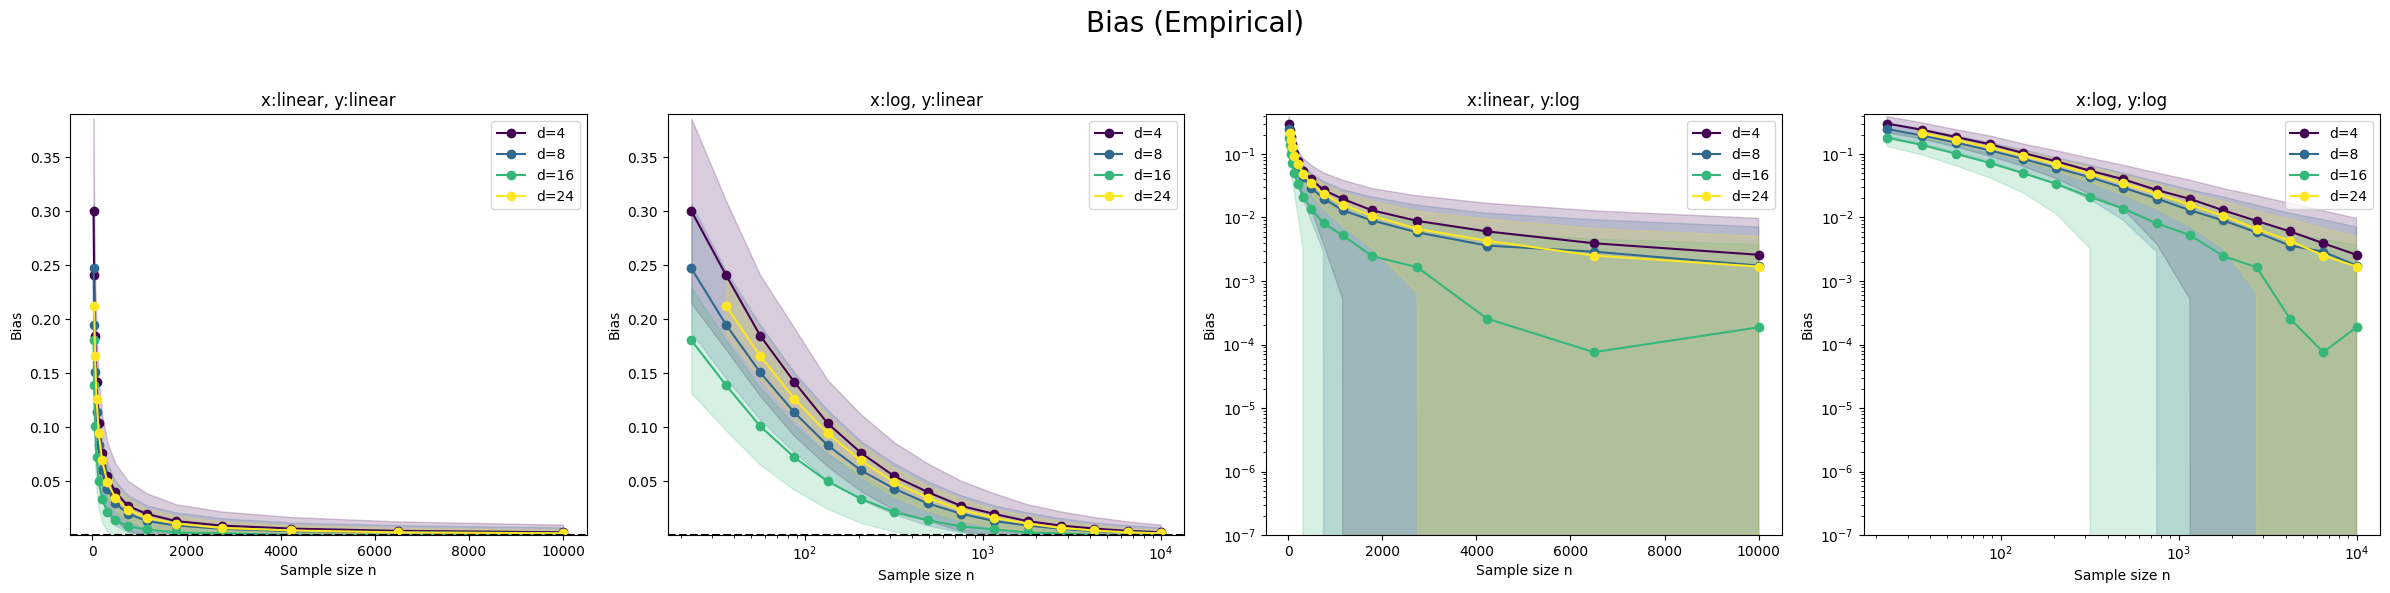

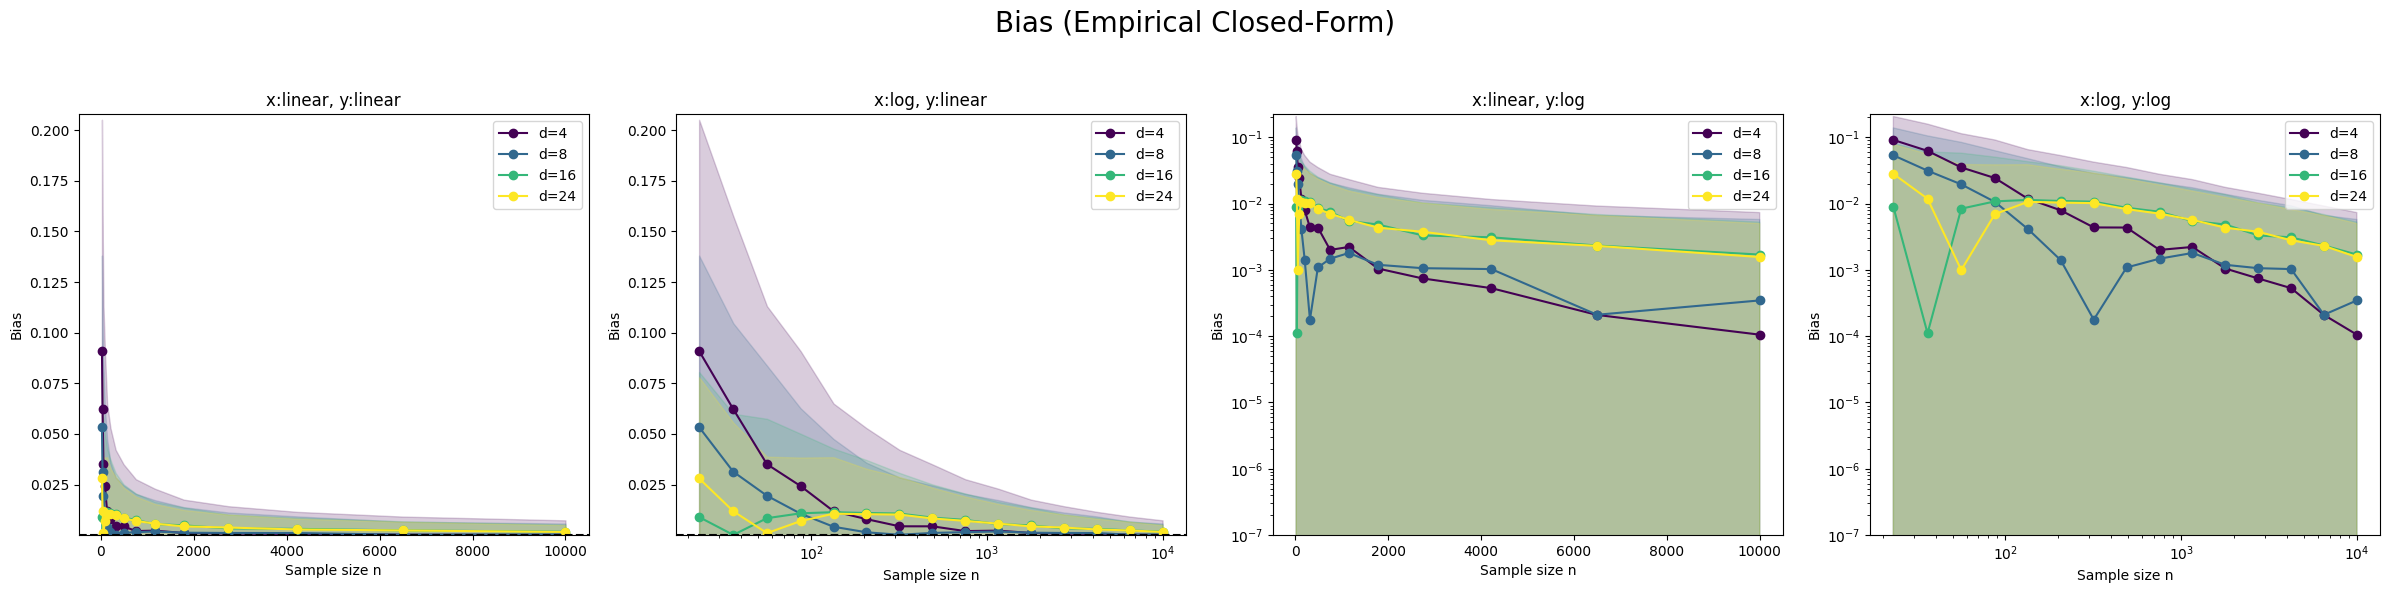

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def riswie_closed_form(cov1, cov2):
    eig1 = np.linalg.eigvalsh(cov1)
    eig2 = np.linalg.eigvalsh(cov2)
    mu = np.sort(np.sqrt(np.maximum(eig1, 0)))
    nu = np.sort(np.sqrt(np.maximum(eig2, 0)))
    return np.linalg.norm(mu - nu) / len(mu)**0.5

def empirical_riswie(X, Y):
    k = min(X.shape[1], Y.shape[1])
    AX = pca_embedding(X, k)
    BY = pca_embedding(Y, k)
    return assignment_sliced_wasserstein(X, Y, AX, BY)

# 4D: 1,2,3,4. 8D: still between 1 and 4, smaller step size.
def random_spd_matrix(d, eig_min=1.0, eig_max=4.0, random_state=None):
    rng = np.random.default_rng(random_state)
    Q, _ = np.linalg.qr(rng.normal(size=(d, d)))
    eigs = rng.uniform(eig_min, eig_max, d) # do 1,4,d
    return Q @ np.diag(eigs) @ Q.T

def experiment_riswie_convergence(
        d=12,
        n_samples=np.logspace(np.log10(12), 5, 32, dtype=int),
        n_repeats=100,
        seed=42):
    print("dimension ", d)
    rng = np.random.default_rng(seed)
    cov1 = random_spd_matrix(d, random_state=seed)
    cov2 = random_spd_matrix(d, random_state=seed+1)
    closed_form = riswie_closed_form(cov1, cov2)
    results = []
    for n in n_samples:
        empirical_vals = []
        empirical_cf_vals = []
        for rep in range(n_repeats):
            X = rng.multivariate_normal(np.zeros(d), cov1, n)
            Y = rng.multivariate_normal(np.zeros(d), cov2, n)
            Xc = X - X.mean(axis=0)
            Yc = Y - Y.mean(axis=0)
            try:
                dist = empirical_riswie(Xc, Yc)
            except Exception:
                dist = np.nan
            empirical_vals.append(dist)
            try:
                emp_cov1 = np.cov(Xc, rowvar=False)
                emp_cov2 = np.cov(Yc, rowvar=False)
                dist_cf = riswie_closed_form(emp_cov1, emp_cov2)
            except Exception:
                dist_cf = np.nan
            empirical_cf_vals.append(dist_cf)
        empirical_vals = np.array(empirical_vals)
        empirical_cf_vals = np.array(empirical_cf_vals)
        mean_emp = np.nanmean(empirical_vals)
        std_emp = np.nanstd(empirical_vals)
        bias = np.abs(mean_emp - closed_form)
        mean_emp_cf = np.nanmean(empirical_cf_vals)
        std_emp_cf = np.nanstd(empirical_cf_vals)
        bias_cf = np.abs(mean_emp_cf - closed_form)
        results.append({
            'n': n,
            'mean': mean_emp,
            'std': std_emp,
            'bias': bias,
            'mean_cf': mean_emp_cf,
            'std_cf': std_emp_cf,
            'bias_cf': bias_cf,
            'closed_form': closed_form
        })
    return results

# --- Main plotting code ---
ds = [4, 8, 16, 24]#, 16, 24, 32, 48, 64] #, 64, 128, 256]
n_samples = np.logspace(np.log10(ds[-1]), 4.0, 15, dtype=int)
n_repeats = 2000  # Lower for dev, increase as needed

# Storage for results
all_results = {d: experiment_riswie_convergence(d=d, n_samples=n_samples, n_repeats=n_repeats, seed=42) for d in ds}

plot_info = [
    ('Empirical RISWIE', 'mean', 'std', 'distance'),
    ('Empirical Closed-Form', 'mean_cf', 'std_cf', 'distance'),
    ('Bias (Empirical)', 'bias', None, 'bias'),
    ('Bias (Empirical Closed-Form)', 'bias_cf', None, 'bias')
]

scales = [
    ('linear', 'linear'),
    ('log', 'linear'),
    ('linear', 'log'),
    ('log', 'log')
]

# generate N distinct colours from, say, the “viridis” colormap
cmap   = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(ds)))   # an array of RGBA tuples

# only the two bias plots, with CI
bias_plot_info = [
    ('Bias (Empirical)',              'bias',    'std',    'Bias'),
    ('Bias (Empirical Closed-Form)',  'bias_cf', 'std_cf', 'Bias')
]

scales = [
    ('linear', 'linear'),
    ('log',    'linear'),
    ('linear', 'log'),
    ('log',    'log')
]

for title, key, std_key, ylab in bias_plot_info:
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    for ax, (xscale, yscale) in zip(axes, scales):
        for idx, d in enumerate(ds):
            results = all_results[d]
            ns   = [r['n']       for r in results]
            vals = [r[key]       for r in results]
            sds  = [r[std_key]   for r in results]
            ax.fill_between(ns,
                            np.array(vals) - np.array(sds),
                            np.array(vals) + np.array(sds),
                            alpha=0.2,
                            color=colors[idx])
            ax.plot(ns,
                    vals,
                    label=f'd={d}',
                    color=colors[idx],
                    marker='o')
        ax.axhline(0, color='black', linestyle='--', lw=1.5)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_xlabel('Sample size n')
        ax.set_ylabel(ylab)
        ax.set_title(f"x:{xscale}, y:{yscale}")
        ax.margins(y=0.01)
        ax.set_ylim(bottom=1e-7)
        ax.legend()
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=[0,0,1,0.94])
    plt.show()


In [54]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and prepare data ---
df = pd.read_csv("Cells/j.csv")
df = df[df["cell_type"].notna()]
df = df[df["region_new"].isin(range(1, 9))]
FEATURE_COLS = ["Xcorr", "Ycorr"]
N_PER_REGION = 2000

# --- Extract 48 regions ---
all_regions = {}
region_keys = []
idx = 0
for file in sorted(df["filename"].unique()):
    for r in range(1, 9):
        sub = df[(df["filename"] == file) & (df["region_new"] == r)]
        if len(sub) >= N_PER_REGION:
            X = sub.sample(n=N_PER_REGION, random_state=0)[FEATURE_COLS].values
            all_regions[idx] = X
            region_keys.append((file, r))
            idx += 1
assert len(all_regions) == 48


In [55]:
def apply_random_2d_rotation(region_dict, seed=0):
    rng = np.random.default_rng(seed)
    rotated = {}
    for r, X in region_dict.items():
        angle = rng.uniform(0, 360)
        theta = np.deg2rad(angle)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]])
        rotated[r] = X @ R.T
    return rotated

all_regions = apply_random_2d_rotation(all_regions)

Computing RISWIE:   0%|          | 0/48 [00:00<?, ?it/s]

Computing RISWIE: 100%|██████████| 48/48 [00:05<00:00,  9.03it/s]


Running farthest-point seeding + global greedy for all 48 starts...


100%|██████████| 48/48 [00:00<00:00, 220.46it/s]



Best assignment (total within-stack sum): 35578.02

--- STACK ASSIGNMENTS ALIGNED TO REGIONS (HUNGARIAN MATCHED) ---
Stack 0 (matched to region 8):
  ('23_06_22_Preprocessed_HuBMAP_19.csv', 8)
  ('23_06_22_Preprocessed_HuBMAP_18.csv', 8)
  ('23_06_22_Preprocessed_HuBMAP_22.csv', 8)
  ('23_06_22_Preprocessed_HuBMAP_21.csv', 8)
  ('23_06_22_Preprocessed_HuBMAP_20.csv', 8)
  ('23_06_22_Preprocessed_HuBMAP_17.csv', 8)
  → Overlap with true region: 6/6

Stack 1 (matched to region 7):
  ('23_06_22_Preprocessed_HuBMAP_18.csv', 7)
  ('23_06_22_Preprocessed_HuBMAP_22.csv', 7)
  ('23_06_22_Preprocessed_HuBMAP_20.csv', 7)
  ('23_06_22_Preprocessed_HuBMAP_21.csv', 7)
  ('23_06_22_Preprocessed_HuBMAP_19.csv', 7)
  ('23_06_22_Preprocessed_HuBMAP_17.csv', 7)
  → Overlap with true region: 6/6

Stack 2 (matched to region 2):
  ('23_06_22_Preprocessed_HuBMAP_17.csv', 6)
  ('23_06_22_Preprocessed_HuBMAP_22.csv', 2)
  ('23_06_22_Preprocessed_HuBMAP_18.csv', 2)
  ('23_06_22_Preprocessed_HuBMAP_21.csv', 2)

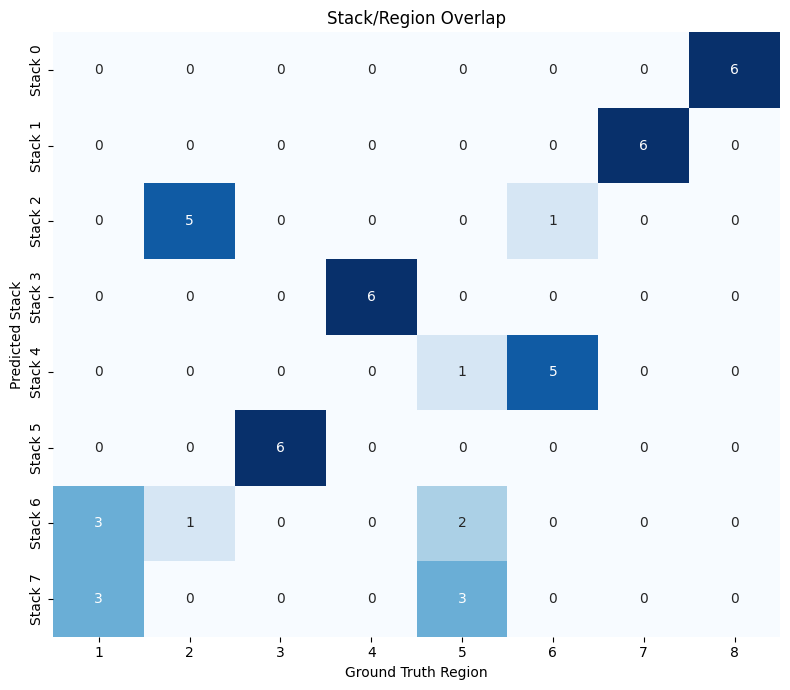

In [ ]:

import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

def spectral_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    k = k if k is not None else min(n - 1, Xc.shape[1])
    #se = SpectralEmbedding(n_components=k, affinity='rbf')
    se = SpectralEmbedding(n_components=k, affinity='nearest_neighbors', n_neighbors=min(10, n-1))
    return se.fit_transform(Xc)

def pca_embedding(X, k=None):
    """
    PCA‐based embedding for 2D data into 4D via projections onto:
      1) u            – first PCA axis
      2) v            – second PCA axis
      3) (u + v)/||u+v||
      4) (u – v)/||u–v||
    """
    X = np.asarray(X)
    n, d = X.shape
    if d != 2:
        raise ValueError("pca_embedding expects X to have shape (n_samples, 2)")

    Xc = X - X.mean(axis=0)

    pca = PCA(n_components=2)
    pca.fit(Xc)
    u, v = pca.components_

    def normalize(w):
        return w / np.linalg.norm(w)

    # build the four unit directions
    dirs = [
        u,
        v,
        normalize(u + v),
        normalize(u - v),
    ]

    # project Xc onto each direction and stack
    Z = np.stack([Xc.dot(d) for d in dirs], axis=1) # result shape: (n_samples, 4)
    return Z

def riswie_distance(X, Y, k=50):
    d = min(X.shape[1], Y.shape[1], X.shape[0], Y.shape[0])
    #k_use = min(k, d)  # Make sure k doesn't exceed available dimension or sample size
    AX = pca_embedding(X)
    BY = pca_embedding(Y)
    #AX = spectral_embedding(X, k)
    #BY = spectral_embedding(Y, k)
    x = assignment_sliced_wasserstein(X, Y, AX, BY)
    #x = gromov_wasserstein(X,Y)
    #x = standard_ot(X,Y)
    #x = sliced_wasserstein(X,Y)
    #print(x)
    return x

# --- RISWIE distance matrix ---
D = np.zeros((48, 48))
for i in tqdm(range(48), desc="Computing RISWIE"):
    for j in range(i + 1, 48):
        D[i, j] = riswie_distance(all_regions[i], all_regions[j])
        D[j, i] = D[i, j]
# --- Farthest point seeding + greedy balanced assignment ---
def farthest_point_seeds(D, n_buckets=8, first_idx=0):  # NOW 8
    seeds = [first_idx]
    candidates = set(range(D.shape[0])) - {first_idx}
    while len(seeds) < n_buckets:
        min_dists = {idx: min(D[idx, s] for s in seeds) for idx in candidates}
        next_seed = max(min_dists, key=min_dists.get)
        seeds.append(next_seed)
        candidates.remove(next_seed)
    return seeds

def globally_greedy_balanced_assignment(D, seeds, bucket_size=6, n_buckets=8):  # NOW 6 per
    n = D.shape[0]
    assigned = np.full(n, -1)
    buckets = [[] for _ in range(n_buckets)]
    for k, s in enumerate(seeds):
        buckets[k].append(s)
        assigned[s] = k
    remaining = set(range(n)) - set(seeds)
    while remaining:
        cost_matrix = np.full((len(remaining), n_buckets), np.inf)
        idx_list = list(remaining)
        for i, idx in enumerate(idx_list):
            for j in range(n_buckets):
                if len(buckets[j]) < bucket_size:
                    cost_matrix[i, j] = sum(D[idx, b] for b in buckets[j])
        min_i, min_j = np.unravel_index(np.argmin(cost_matrix), cost_matrix.shape)
        idx_to_assign = idx_list[min_i]
        buckets[min_j].append(idx_to_assign)
        assigned[idx_to_assign] = min_j
        remaining.remove(idx_to_assign)
    return buckets

def stack_total_within_sum(buckets, D):
    return sum(
        sum(D[i, j] for i, j in combinations(bucket, 2))
        for bucket in buckets
    )
# --- Run over all possible initial seeds ---
all_assignments = []
all_scores = []
print("Running farthest-point seeding + global greedy for all 48 starts...")
for start in tqdm(range(48)):
    seeds = farthest_point_seeds(D, n_buckets=8, first_idx=start)
    buckets = globally_greedy_balanced_assignment(D, seeds, bucket_size=6, n_buckets=8)
    score = stack_total_within_sum(buckets, D)
    all_assignments.append(buckets)
    all_scores.append(score)
# --- Select best ---
best_idx = int(np.argmin(all_scores))
stacks = all_assignments[best_idx]
print(f"\nBest assignment (total within-stack sum): {all_scores[best_idx]:.2f}")
# --- Ground truth stacks by region ---
regions = sorted(set([region for (_, region) in region_keys]))
true_stacks = [
    [i for i, (_, region) in enumerate(region_keys) if region == r]
    for r in regions
]

# --- Hungarian alignment of predicted to true stacks ---
cost = np.zeros((8, 8))
for i, pred_stack in enumerate(stacks):
    for j, true_stack in enumerate(true_stacks):
        cost[i, j] = -len(set(pred_stack) & set(true_stack))
row_ind, col_ind = linear_sum_assignment(cost)




# --- Print results ---
total_correct = 0
print("\n--- STACK ASSIGNMENTS ALIGNED TO REGIONS (HUNGARIAN MATCHED) ---")
for pred_k, true_k in zip(row_ind, col_ind):
    region_ids = stacks[pred_k]
    files = [region_keys[i][0] for i in region_ids]
    counter = Counter(files)
    true_region = regions[true_k]
    n_overlap = len(set(region_ids) & set(true_stacks[true_k]))
    total_correct += n_overlap
    print(f"Stack {pred_k} (matched to region {true_region}):")
    for i in region_ids:
        print(f"  {region_keys[i]}")
    print(f"  → Overlap with true region: {n_overlap}/6\n")
print(f"\nTotal correct: {total_correct}/48\n")

# Build 8x8 confusion matrix: stack i vs true region j
conf_mat = np.zeros((8, 8), dtype=int)
region_to_idx = {r: j for j, r in enumerate(regions)}
for pred_k, true_k in zip(row_ind, col_ind):
    region_ids = stacks[pred_k]
    for i in region_ids:
        region = region_keys[i][1]
        j = region_to_idx[region]
        conf_mat[pred_k, j] += 1
# Plot
plt.figure(figsize=(8, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[str(r) for r in regions],
            yticklabels=[f"Stack {i}" for i in range(8)])
plt.xlabel("Ground Truth Region")
plt.ylabel("Predicted Stack")
plt.title("Stack/Region Overlap")
plt.tight_layout()
plt.show()



Using distance: riswie


Computing riswie: 100%|██████████| 48/48 [00:06<00:00,  7.22it/s]



Best assignment found in greedy search (total within-stack sum): 29348.08
Ground truth assignment cost (if we chose it): 29922.59

--- STACK ASSIGNMENTS ALIGNED TO REGIONS (HUNGARIAN MATCHED) ---
Stack 0 (matched to region 2): 5/6 correct
Stack 1 (matched to region 8): 6/6 correct
Stack 2 (matched to region 5): 5/6 correct
Stack 3 (matched to region 4): 6/6 correct
Stack 4 (matched to region 6): 6/6 correct
Stack 5 (matched to region 1): 6/6 correct
Stack 6 (matched to region 3): 6/6 correct
Stack 7 (matched to region 7): 6/6 correct

Total correct: 46/48



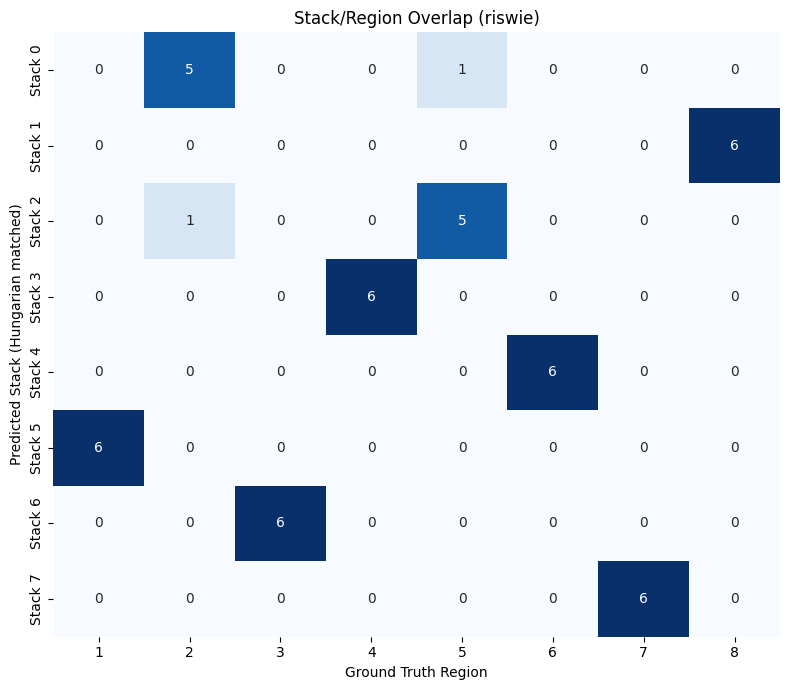

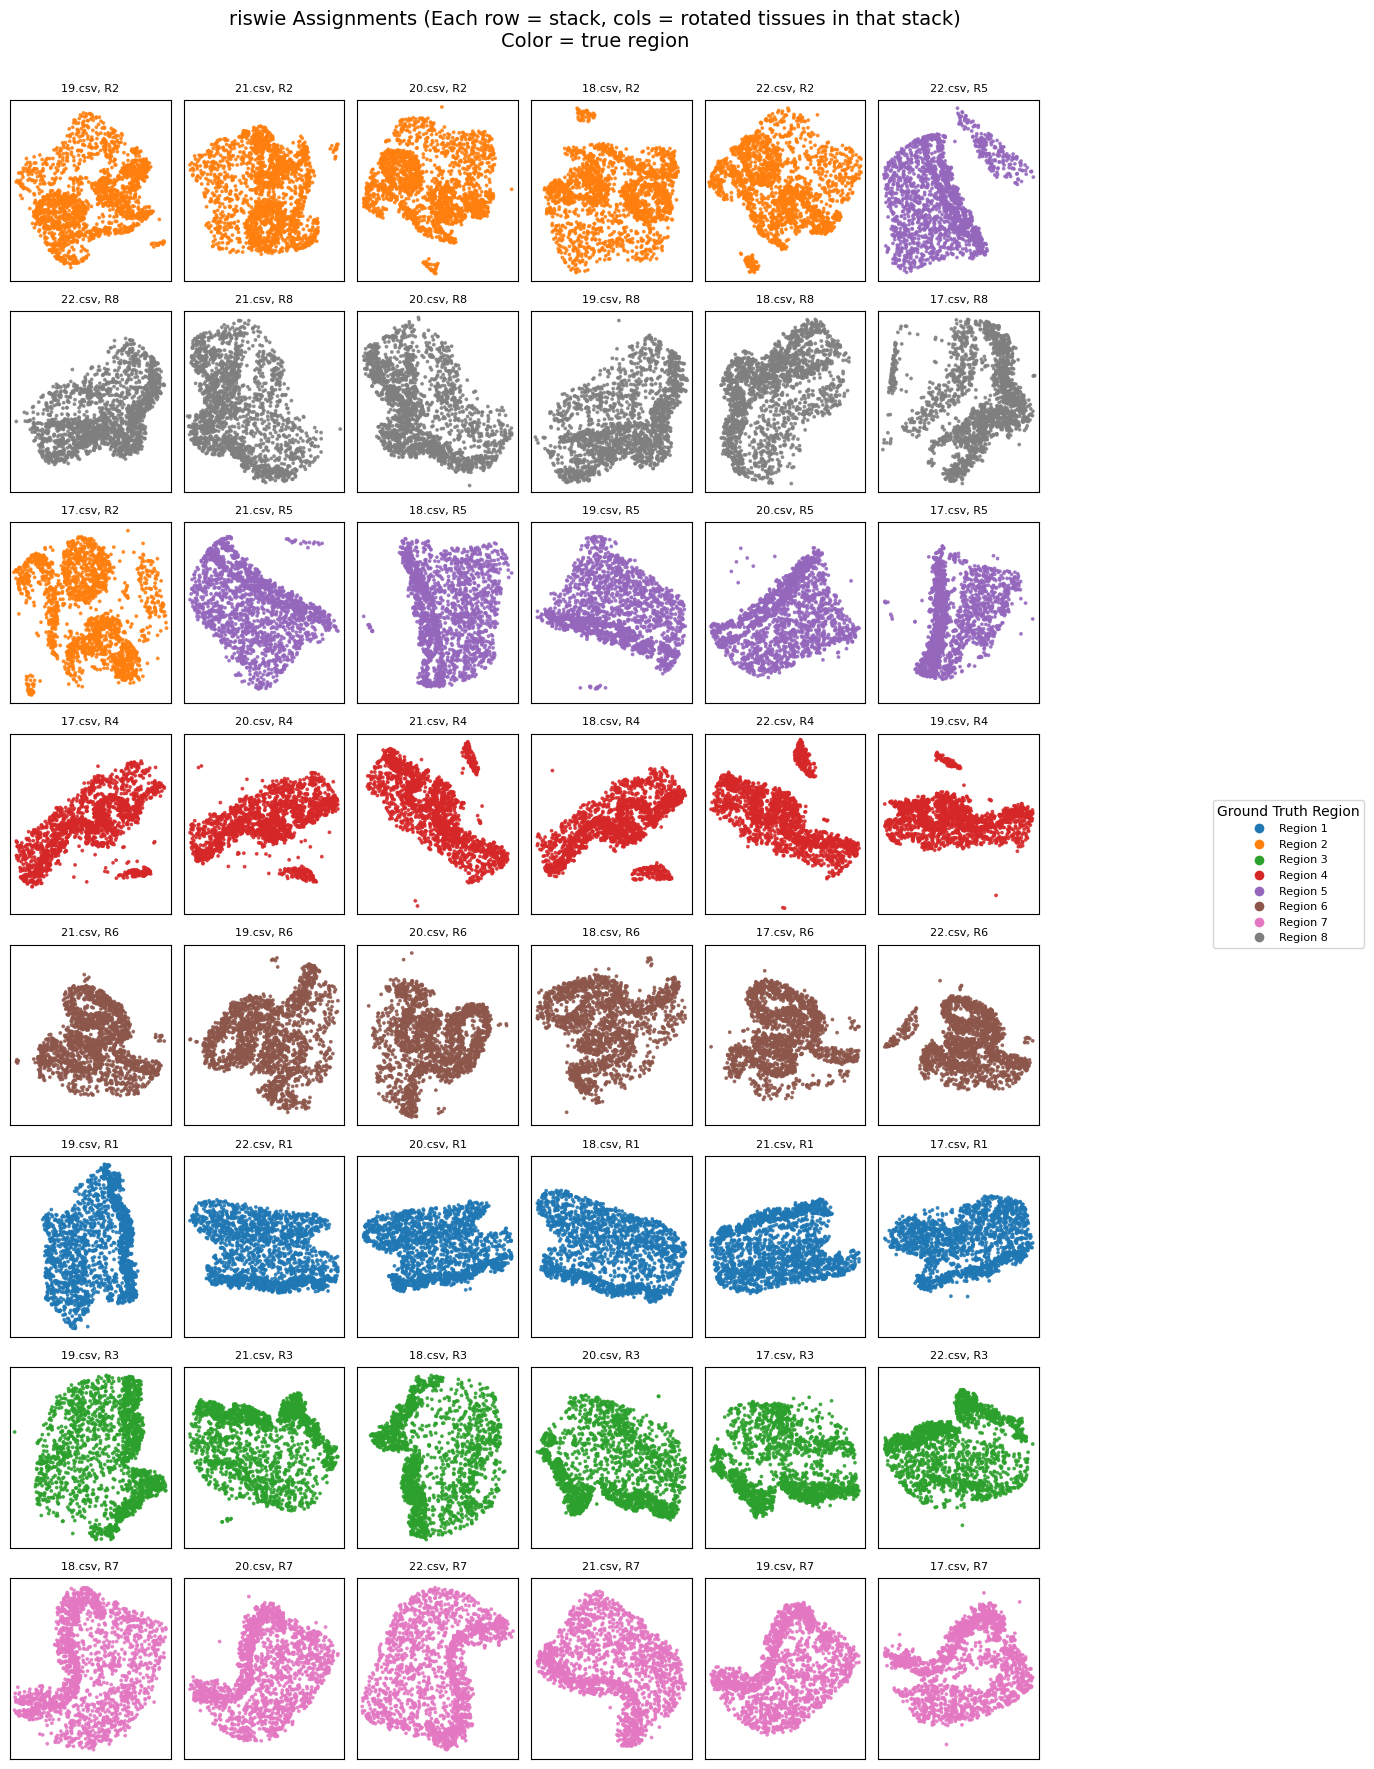


Using distance: sliced


Computing sliced: 100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# ... (your embedding and helper functions here)

# --- Put your distance functions in a dict ---
distance_functions = {
    "riswie": assignment_sliced_wasserstein,
    "sliced": sliced_wasserstein,
    "ot": standard_ot,
    "gromov": gromov_wasserstein,
}

for dist_name, dist_func in distance_functions.items():
    print(f"\n{'='*20}\nUsing distance: {dist_name}\n{'='*20}")

    def riswie_distance(X, Y, k=50):
        d = min(X.shape[1], Y.shape[1], X.shape[0], Y.shape[0])
        k_use = min(k, d)
        AX = pca_embedding(X, k_use)
        BY = pca_embedding(Y, k_use)
        if dist_name == "riswie":
            return assignment_sliced_wasserstein(X, Y, AX, BY)
        elif dist_name == "sliced":
            return sliced_wasserstein(X, Y)
        elif dist_name == "gromov":
            return gromov_wasserstein(X, Y)
        elif dist_name == "ot":
            return standard_ot(X, Y)
        else:
            raise ValueError(f"Unknown distance: {dist_name}")

    # --- RISWIE distance matrix ---
    D = np.zeros((48, 48))
    for i in tqdm(range(48), desc=f"Computing {dist_name}"):
        for j in range(i + 1, 48):
            D[i, j] = riswie_distance(all_regions[i], all_regions[j])
            D[j, i] = D[i, j]

    # --- Farthest point seeding + greedy balanced assignment ---
    # 48 deterministic seeds
    all_assignments = []
    all_scores = []
    for start in range(48):
        seeds = farthest_point_seeds(D, n_buckets=8, first_idx=start)
        buckets = globally_greedy_balanced_assignment(D, seeds, bucket_size=6, n_buckets=8)
        score = stack_total_within_sum(buckets, D)
        all_assignments.append(buckets)
        all_scores.append(score)

    # Also try a lot of random seeds to explore more
    for _ in range(100000):
        # Draw 8 unique regions at random for seeds
        seeds = np.random.choice(np.arange(48), size=8, replace=False).tolist()
        buckets = globally_greedy_balanced_assignment(D, seeds, bucket_size=6, n_buckets=8)
        score = stack_total_within_sum(buckets, D)
        all_assignments.append(buckets)
        all_scores.append(score)

    best_idx = int(np.argmin(all_scores))
    stacks = all_assignments[best_idx]
    print(f"\nBest assignment found in greedy search (total within-stack sum): {all_scores[best_idx]:.2f}")
    gt_cost = stack_total_within_sum(true_stacks, D)
    print(f"Ground truth assignment cost (if we chose it): {gt_cost:.2f}")

    # --- Ground truth stacks by region ---
    regions = sorted(set([region for (_, region) in region_keys]))
    true_stacks = [
        [i for i, (_, region) in enumerate(region_keys) if region == r]
        for r in regions
    ]

    # --- Hungarian alignment of predicted to true stacks ---
    cost = np.zeros((8, 8))
    for i, pred_stack in enumerate(stacks):
        for j, true_stack in enumerate(true_stacks):
            cost[i, j] = -len(set(pred_stack) & set(true_stack))
    row_ind, col_ind = linear_sum_assignment(cost)

    # --- Print results and total correct ---
    total_correct = 0
    print("\n--- STACK ASSIGNMENTS ALIGNED TO REGIONS (HUNGARIAN MATCHED) ---")
    for pred_k, true_k in zip(row_ind, col_ind):
        region_ids = stacks[pred_k]
        n_overlap = len(set(region_ids) & set(true_stacks[true_k]))
        total_correct += n_overlap
        print(f"Stack {pred_k} (matched to region {regions[true_k]}): {n_overlap}/6 correct")
    print(f"\nTotal correct: {total_correct}/48\n")

     # --- 8x8 Confusion matrix: pred stack vs true region ---
    conf_mat = np.zeros((8, 8), dtype=int)
    region_to_idx = {r: j for j, r in enumerate(regions)}
    for pred_k, true_k in zip(row_ind, col_ind):
        region_ids = stacks[pred_k]
        for i in region_ids:
            region = region_keys[i][1]
            j = region_to_idx[region]
            conf_mat[pred_k, j] += 1

    plt.figure(figsize=(8,7))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=[str(r) for r in regions],
                yticklabels=[f"Stack {i}" for i in range(8)])
    plt.xlabel("Ground Truth Region")
    plt.ylabel("Predicted Stack (Hungarian matched)")
    plt.title(f"Stack/Region Overlap ({dist_name})")
    plt.tight_layout()
    plt.show()

    # For each region_idx, get the original DataFrame subset
    def get_labels_for_region(region_idx):
        file, region = region_keys[region_idx]
        sub = df[(df["filename"] == file) & (df["region_new"] == region)]
        # Use same random_state as in region extraction
        labels = sub.sample(n=N_PER_REGION, random_state=0)["cell_type"].values
        return labels
    all_cell_types = df["cell_type"].unique()
    palette = sns.color_palette("tab20", n_colors=len(all_cell_types))
    color_map = dict(zip(all_cell_types, palette))

    # Build consistent color map for regions (ground truth)
    regions_sorted = sorted(set([region for (_, region) in region_keys]))
    region_palette = sns.color_palette("tab10", n_colors=8)
    region_color_map = dict(zip(regions_sorted, region_palette))

    fig, axes = plt.subplots(8, 6, figsize=(12, 18), sharex=False, sharey=False)

    for stack_idx, pred_stack in enumerate(stacks):
        for i, region_idx in enumerate(pred_stack):
            # Rotated X, Y for this tissue
            XY = all_regions[region_idx]  # shape (N_PER_REGION, 2)
            xvals, yvals = XY[:,0], XY[:,1]
            file, region = region_keys[region_idx]
            color = region_color_map[region]  # Assign the region's color to every cell
            ax = axes[stack_idx, i]
            ax.scatter(xvals, yvals, c=[color]*len(xvals), s=3, alpha=0.8)
            ax.set_title(f"{file[-6:]}, R{region}", fontsize=8)
            ax.axis("equal")
            ax.set_xticks([])
            ax.set_yticks([])

    # Legend for regions
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                        label=f"Region {region}", markerfacecolor=region_color_map[region], markersize=8)
            for region in regions_sorted]
    fig.legend(handles=handles, title="Ground Truth Region", bbox_to_anchor=(1.01, 0.5),
            loc="center left", fontsize=8)
    plt.suptitle(f"{dist_name} Assignments (Each row = stack, cols = rotated tissues in that stack)\nColor = true region", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(right=0.87, top=0.93)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD

def riswie_distance(X, Y, k=10):
    d = min(X.shape[1], Y.shape[1], X.shape[0], Y.shape[0])
    k_use = min(k, d)
    AX = pca_embedding(X, k_use)
    BY = pca_embedding(Y, k_use)
    return assignment_sliced_wasserstein(X, Y, AX, BY)

# --- Build the pairwise RISWIE distance matrix as before ---
# Assume D, all_regions, region_keys, and related setup are already done

n_regions = 48
n_stacks = 8
group_size = 6

print("Building pairwise RISWIE distance matrix...")
D = np.zeros((n_regions, n_regions))
for i in tqdm(range(n_regions), desc="RISWIE D"):
    for j in range(i + 1, n_regions):
        D[i, j] = riswie_distance(all_regions[i], all_regions[j])
        D[j, i] = D[i, j]


# --- ILP Setup ---
x = np.array([[LpVariable(f"x_{i}_{k}", cat=LpBinary) for k in range(n_stacks)] for i in range(n_regions)])
y = {}

prob = LpProblem("Stacking_min_RISWIE", LpMinimize)

# Each region assigned to exactly one stack
for i in range(n_regions):
    prob += lpSum(x[i, k] for k in range(n_stacks)) == 1

# Each stack has exactly group_size regions
for k in range(n_stacks):
    prob += lpSum(x[i, k] for i in range(n_regions)) == group_size

# Create y[i,j,k]: 1 if both i and j are in group k, else 0
for k in range(n_stacks):
    for i, j in combinations(range(n_regions), 2):
        var = LpVariable(f"y_{i}_{j}_{k}", cat=LpBinary)
        y[(i, j, k)] = var
        prob += var <= x[i, k]
        prob += var <= x[j, k]
        prob += var >= x[i, k] + x[j, k] - 1

# Objective: sum of distances for all pairs in all stacks
objective = lpSum(D[i, j] * y[(i, j, k)] for k in range(n_stacks) for i, j in combinations(range(n_regions), 2))
prob += objective

# --- SOLVE ---
print("Solving ILP... (this can take a while for 48 regions!)")
prob.solve(PULP_CBC_CMD(msg=True))
print("ILP Solution Status:", prob.status)

# --- EXTRACT STACKS ---
stacks = [[] for _ in range(n_stacks)]
for i in range(n_regions):
    for k in range(n_stacks):
        if x[i, k].varValue > 0.5:
            stacks[k].append(i)

print("\n--- ILP Stack Assignments ---")
for k in range(n_stacks):
    print(f"Stack {k}: {[region_keys[i] for i in stacks[k]]}")

# --- Evaluate with Hungarian alignment to true region stacks ---
regions = sorted(set([region for (_, region) in region_keys]))
true_stacks = [
    [i for i, (_, region) in enumerate(region_keys) if region == r]
    for r in regions
]

cost = np.zeros((8, 8))
for i, pred_stack in enumerate(stacks):
    for j, true_stack in enumerate(true_stacks):
        cost[i, j] = -len(set(pred_stack) & set(true_stack))
row_ind, col_ind = linear_sum_assignment(cost)

print("\n--- STACK ASSIGNMENTS ALIGNED TO REGIONS (HUNGARIAN MATCHED) ---")
for pred_k, true_k in zip(row_ind, col_ind):
    region_ids = stacks[pred_k]
    files = [region_keys[i][0] for i in region_ids]
    counter = Counter(files)
    true_region = regions[true_k]
    n_overlap = len(set(region_ids) & set(true_stacks[true_k]))
    print(f"Stack {pred_k} (matched to region {true_region}):")
    for i in region_ids:
        print(f"  {region_keys[i]}")
    print(f"  → Overlap with true region: {n_overlap}/6\n")

# Build 8x8 confusion matrix: stack i vs true region j
conf_mat = np.zeros((8, 8), dtype=int)
region_to_idx = {r: j for j, r in enumerate(regions)}
for pred_k, true_k in zip(row_ind, col_ind):
    region_ids = stacks[pred_k]
    for i in region_ids:
        region = region_keys[i][1]
        j = region_to_idx[region]
        conf_mat[pred_k, j] += 1
# Plot
plt.figure(figsize=(8, 7))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[str(r) for r in regions],
            yticklabels=[f"Stack {i}" for i in range(8)])
plt.xlabel("Ground Truth Region")
plt.ylabel("Predicted Stack")
plt.title("Stack/Region Overlap (ILP Assignment)")
plt.tight_layout()
plt.show()


Building pairwise RISWIE distance matrix...


RISWIE D: 100%|██████████| 48/48 [00:07<00:00,  6.31it/s]


Solving ILP... (this can take a while for 48 regions!)
